In [46]:
from skimage import morphology as mo
import numpy as np
import matplotlib.pyplot as plt
import skimage as ski
from skimage.morphology import skeletonize , medial_axis
from skimage.util import invert
from scipy import ndimage as ndi
import cv2 as cv
from scipy.ndimage import convolve
import yaml
import networkx as nx
import matplotlib.pyplot as plt


In [47]:
# version chat gpt
import numpy as np
from scipy.ndimage import label, center_of_mass

def chebyshev_distance(p1, p2):
    return max(abs(p1[0] - p2[0]), abs(p1[1] - p2[1]))

def separarDT(image, k):
    binary_image = (image > 0).astype(np.uint8)  # Convertir a binario
    labeled, num_features = label(binary_image)  # Etiquetar componentes conectados
    
    pixel_groups = []
    trifurcacion = []
    for i in range(1, num_features + 1):
        pixels = np.column_stack(np.where(labeled == i))  # Extraer píxeles del componente
        merged = False
        
        for group in pixel_groups:
            if any(chebyshev_distance(p, pixels[0]) <= k for p in group):
                group.extend(pixels.tolist())
                merged = True
                break
        
        if not merged:
            pixel_groups.append(pixels.tolist())
   
    new_image = np.zeros_like(image)
    new_image2 = np.zeros_like(image)
    for group in pixel_groups:
        if len(group) > 1:
            centroid = np.round(np.mean(group, axis=0)).astype(int)
            new_image[tuple(centroid)] = 255  # Marcar píxel blanco
        else:
            new_image2[tuple(group[0])] = 255  # Marcar píxel blanco
    
    return new_image, new_image2




In [48]:
S1 = np.array((
        [ 0,-1, 0],
        [ 1, 1, 1],
        [-1, 1,-1]), dtype="int")
S2 = np.array((
        [0, -1, 1],
        [1, 1, -1],
        [-1, 1, 0]), dtype="int")

S3 = np.array((
        [ 0,-1, 1],
        [ 1, 1,-1],
        [ 0,-1, 1]), dtype="int") 
S4 = np.array((
        [-1,-1, 1],
        [-1, 1,-1],
        [ 1,-1, 1]), dtype="int") 
S1f = np.array((
        [-1,-1,-1],
        [ 1, 1,-1],
        [-1,-1,-1]), dtype="int")
S2f = np.array((
        [-1,-1, 1],
        [-1, 1,-1],
        [-1,-1,-1]), dtype="int")

def detector(I,S):
    I = I.astype(np.uint8)
    H = I[:,:] *0
    for i in range(4):
        S = np.rot90(S)
        H = H + cv.morphologyEx(I, cv.MORPH_HITMISS, S)
    return H
        

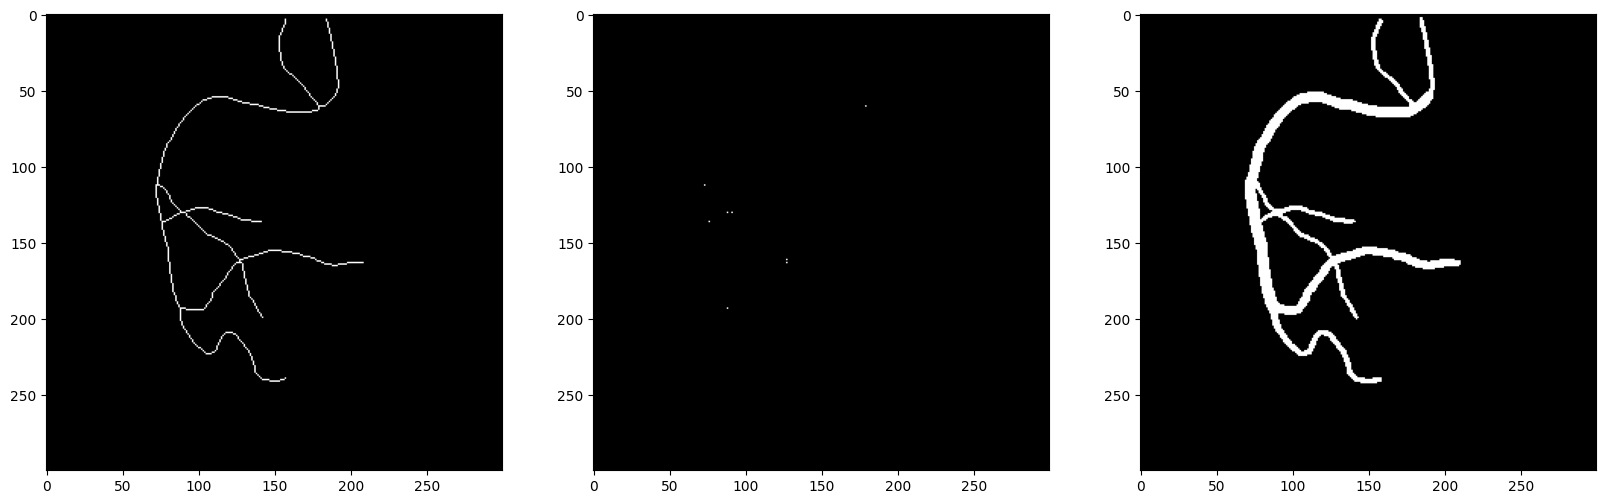

[[ 60 179]
 [112  73]
 [130  88]
 [130  91]
 [136  76]
 [161 127]
 [163 127]
 [193  88]]


In [49]:
I = plt.imread('database/1_gt.pgm')
I = I/255

#I = (ski.color.rgb2gray(I* 255)).astype(np.uint8)
T = skeletonize(I)
# Supongamos que R, G y B son imágenes en escala de grises con el mismo tamaño
R0 = detector(T,S1) + detector(T,S2) + detector(T,S3) + detector(T,S4) # Canal Rojo
plt.figure(figsize=(20,20))
plt.subplot(1,3,1) 
plt.imshow(T,cmap='gray', vmin=0, vmax=1)
plt.subplot(1,3,2)                                 
plt.imshow(R0,cmap='gray', vmin=0, vmax=1)
plt.subplot(1,3,3)                                 
plt.imshow(I,cmap='gray', vmin=0, vmax=1)
plt.show()
print(np.argwhere(R0 > 0))

In [52]:

def furcaciones(I):
    """
    Recive una imagen _gt y devuelve:
    D: np.array: coordenadas en la imágen de las aristas de difurcacion (conectadas a otras 3 aristas)
    T: np.array: coordenadas en la imágen de las aristas de trifurcaciones (conectadas a otras 4 aristas)
    E: np.array: coordenadas en la imágen de las aristas terminles (solo se conectan a una arista)
    
    """
    I = I/255
    #I = (ski.color.rgb2gray(I* 255)).astype(np.uint8)
    T = skeletonize(I)
    # Supongamos que R, G y B son imágenes en escala de grises con el mismo tamaño
    R0 = detector(T,S1) + detector(T,S2) + detector(T,S3) + detector(T,S4) # Canal Rojo
    G0 = detector(T,S1f) + detector(T,S2f)    # Canal Verde
    B0, R0 = separarDT(R0,4)
    D = np.argwhere(R0 > 0)
    T = np.argwhere(B0 > 0)
    E = np.argwhere(G0 > 0)

    # completa la parte que encuentra I 
    # 
    #
    I = 0  
    return D , T, E 


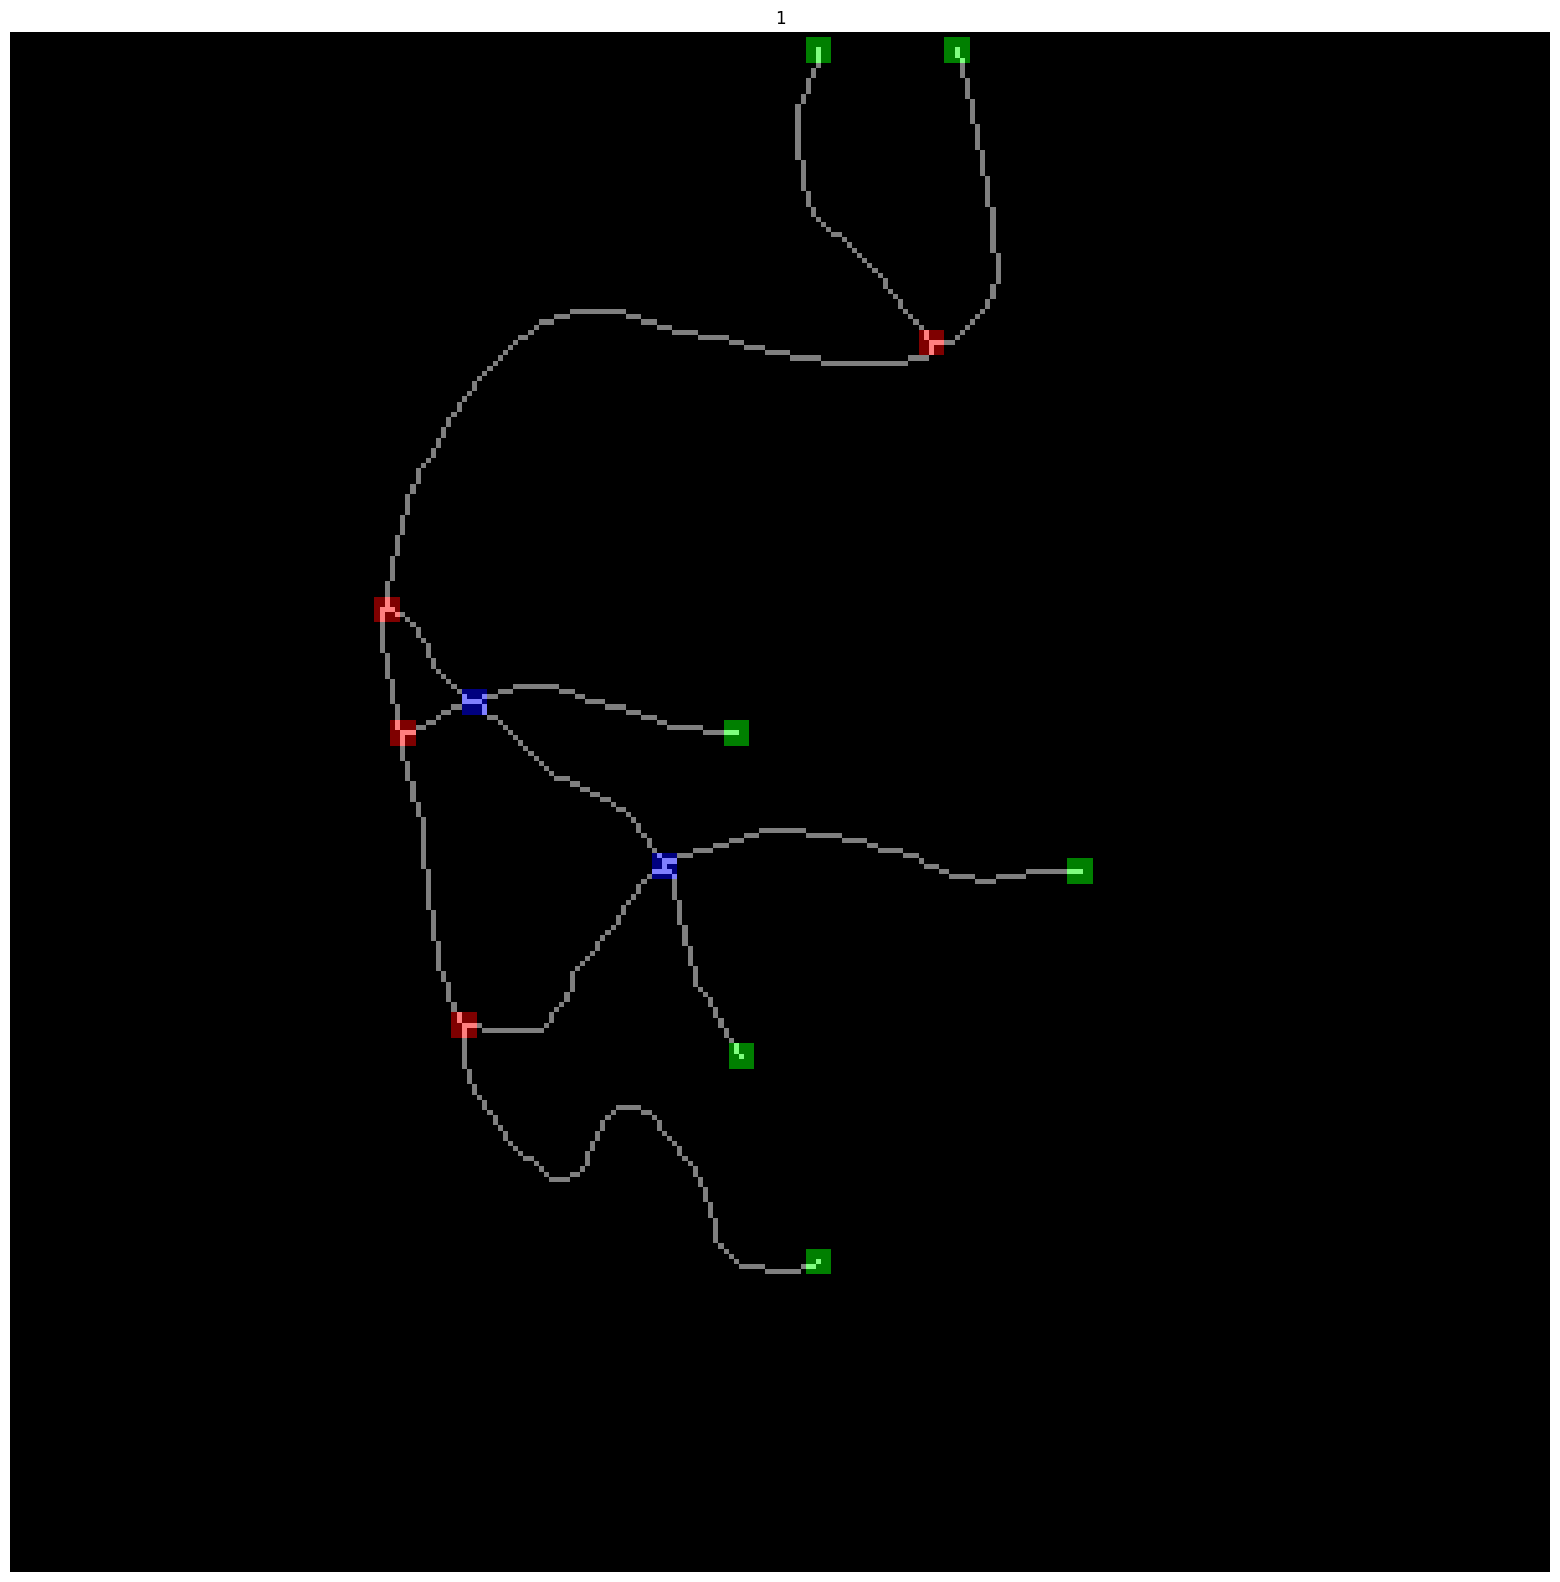

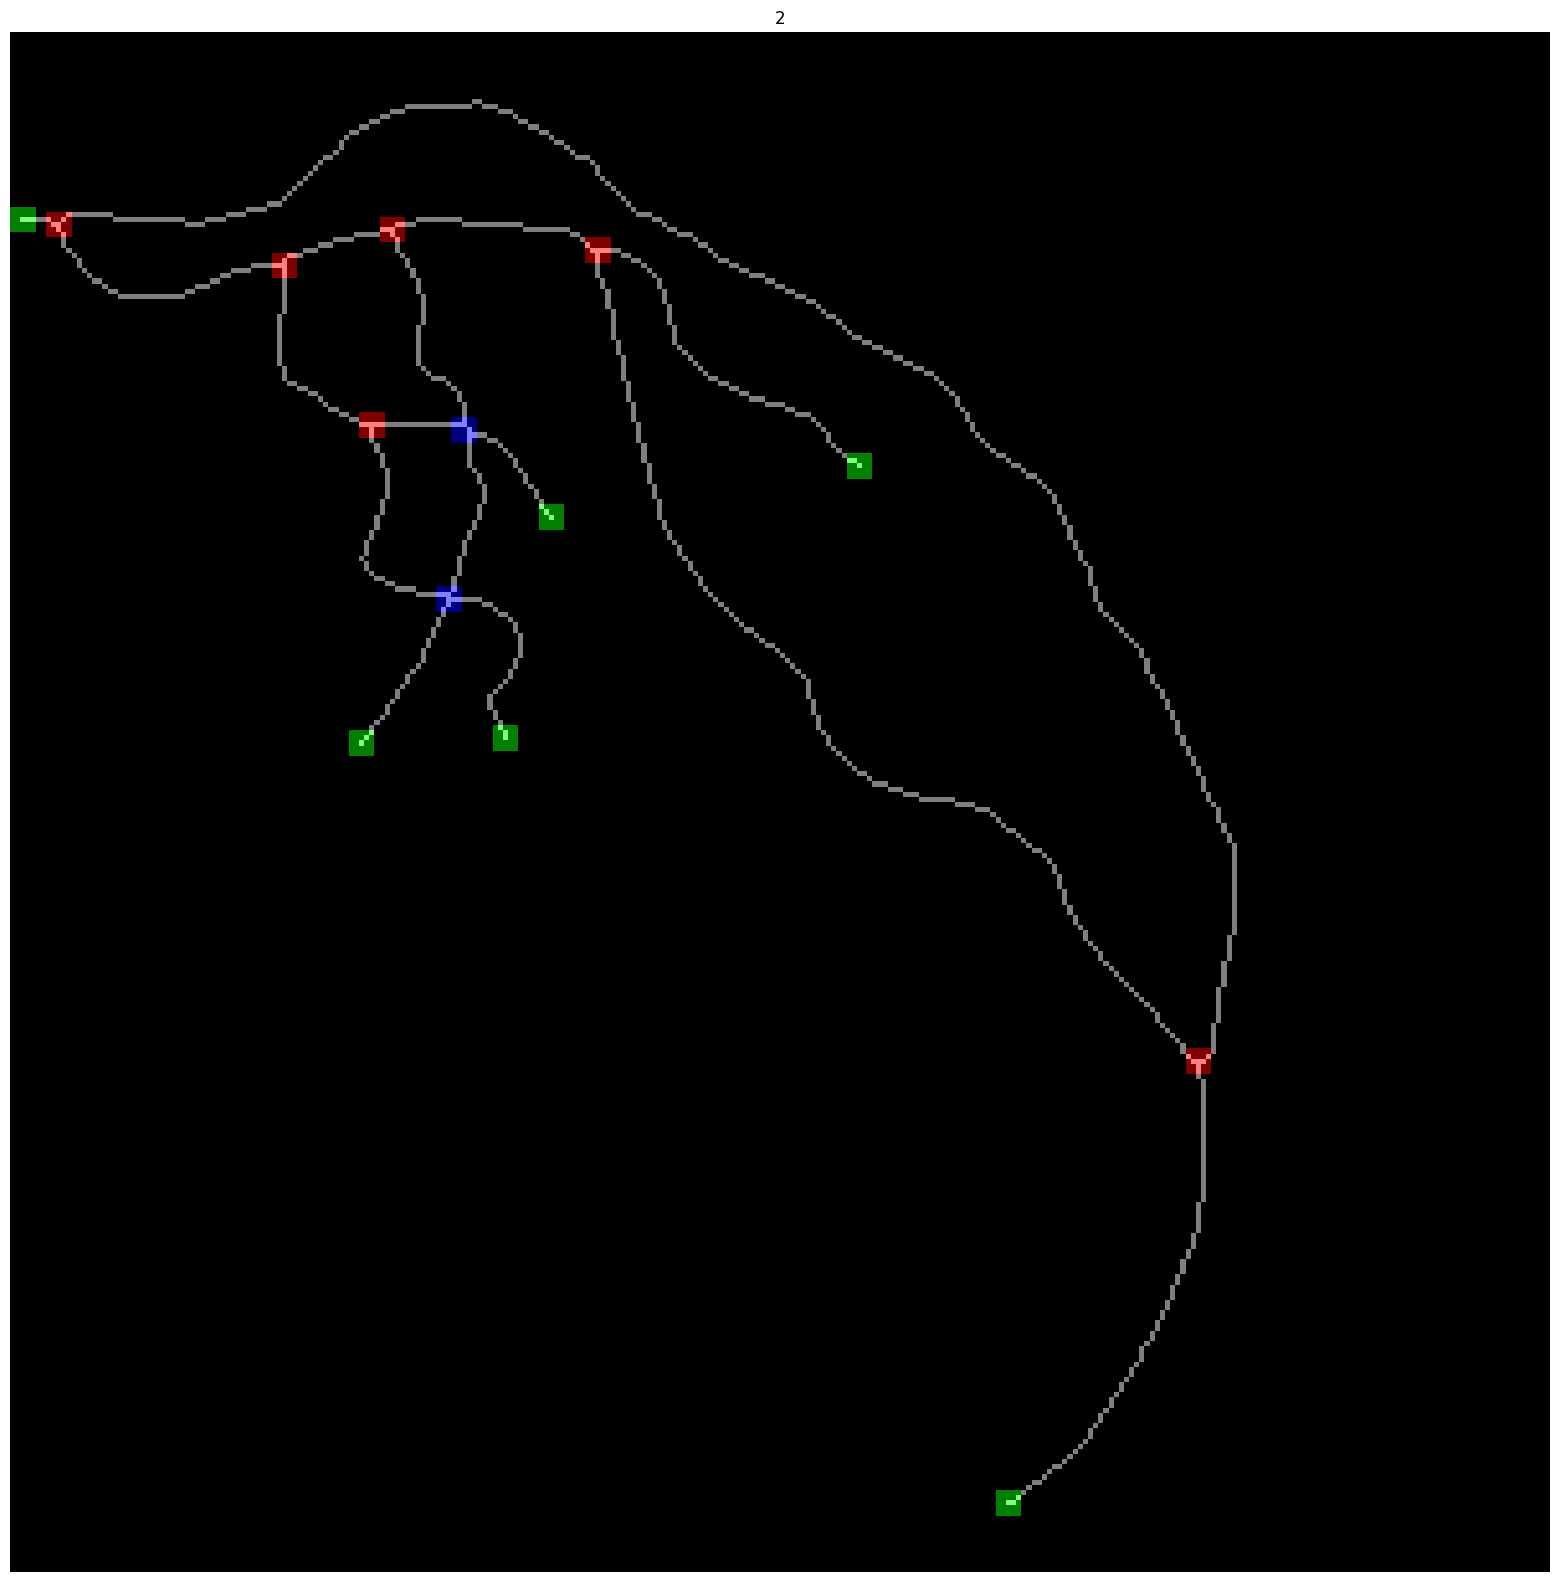

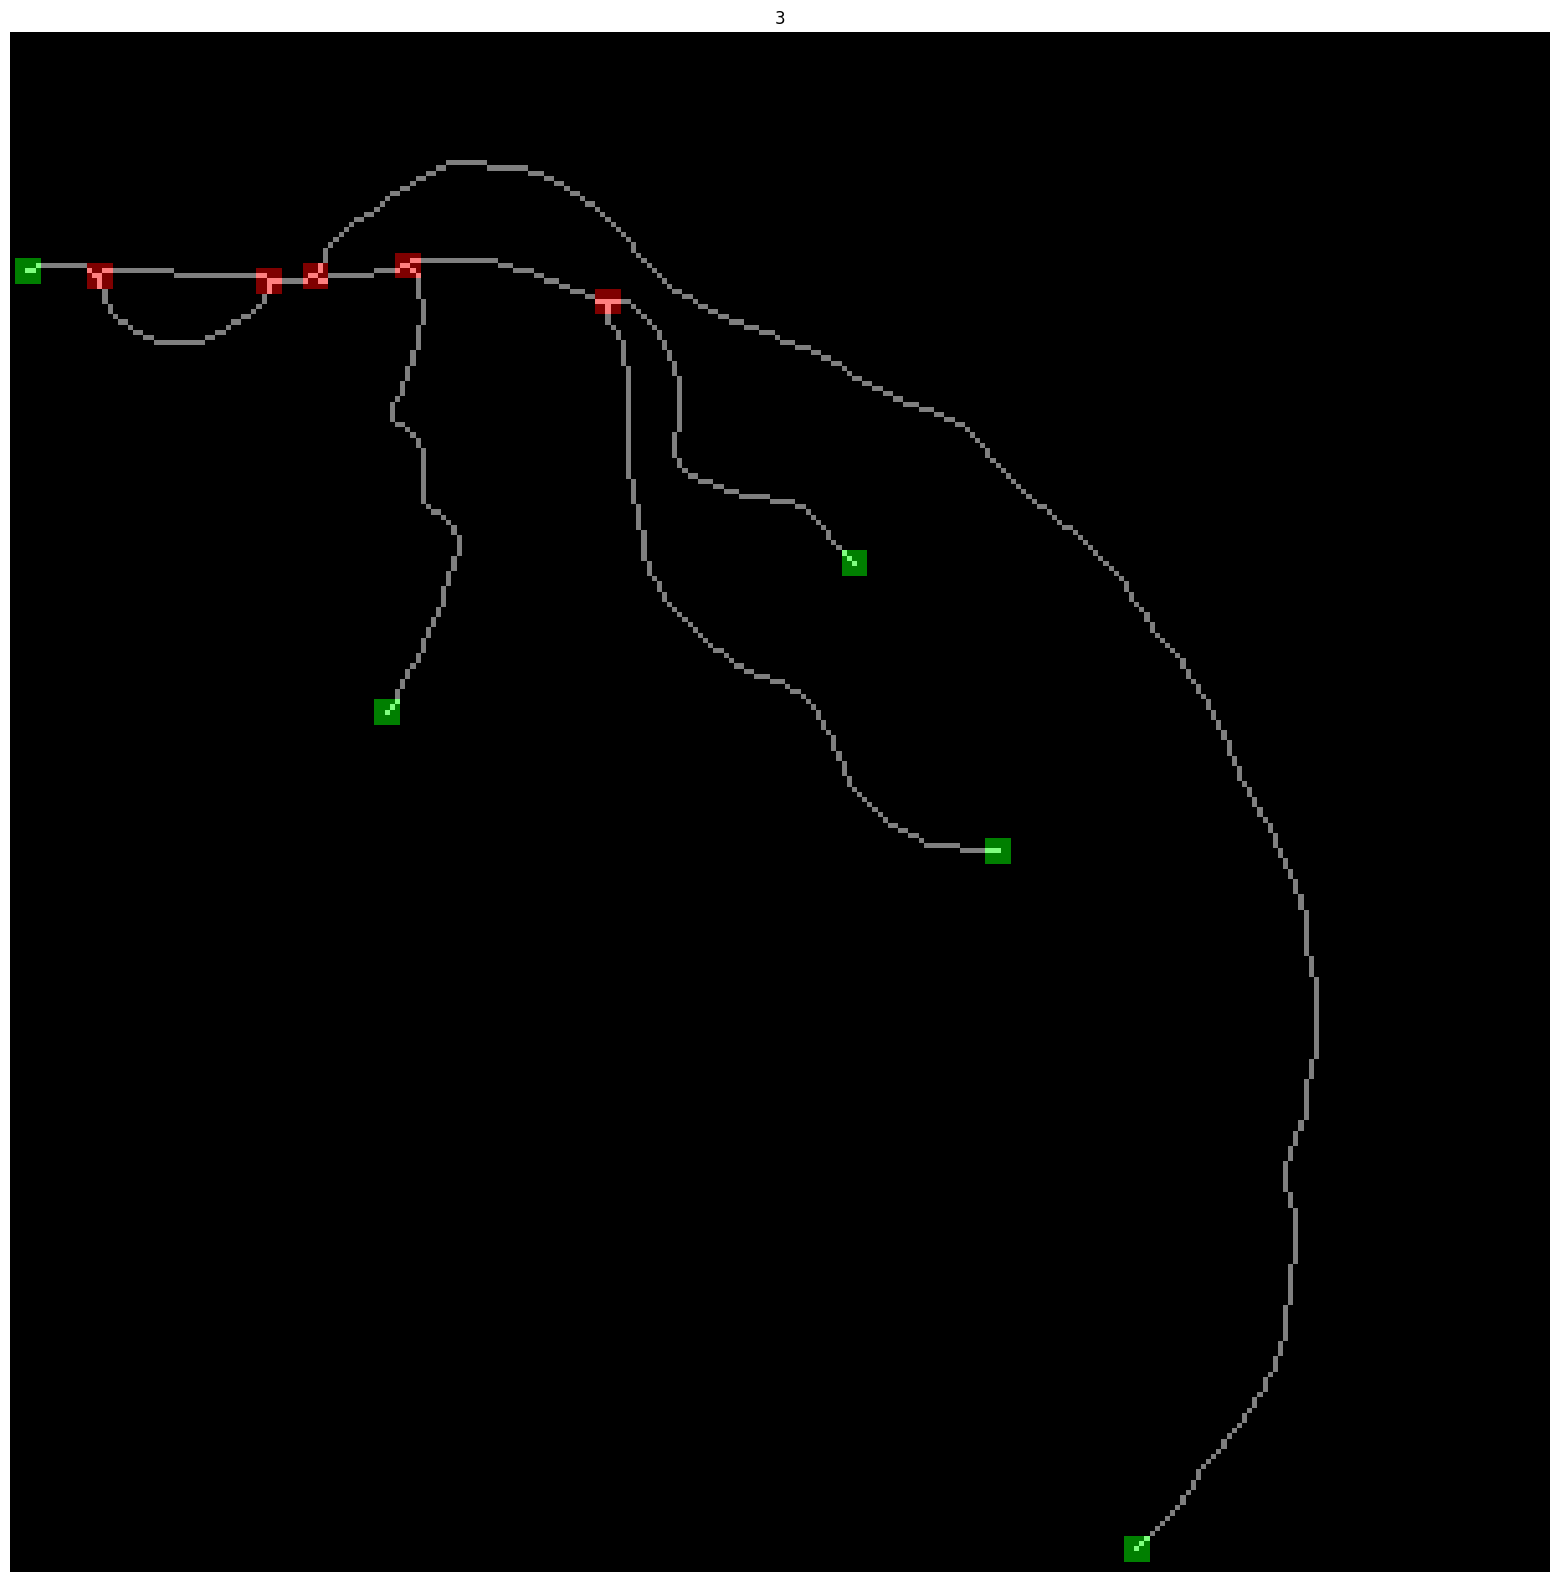

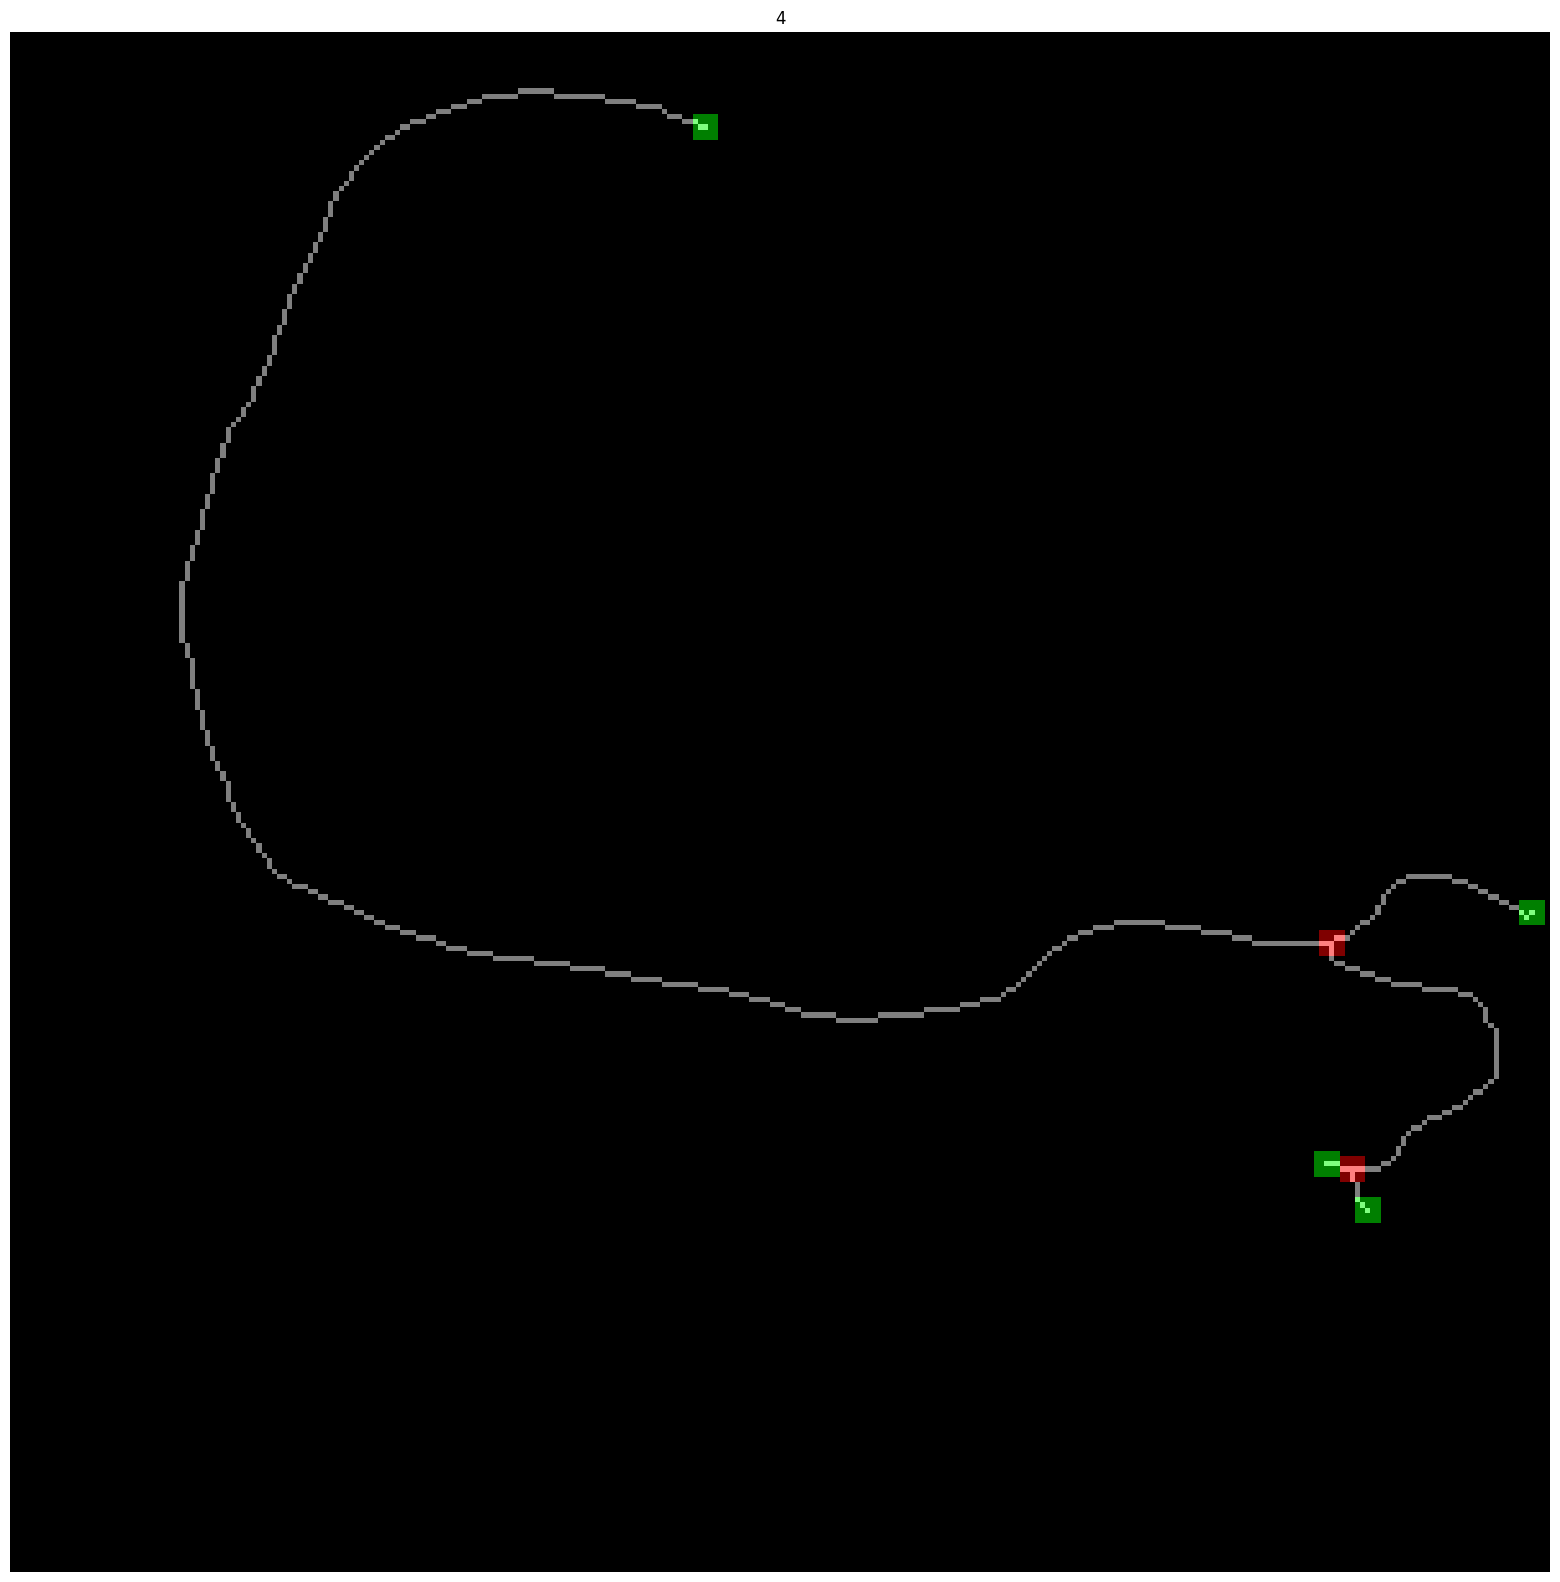

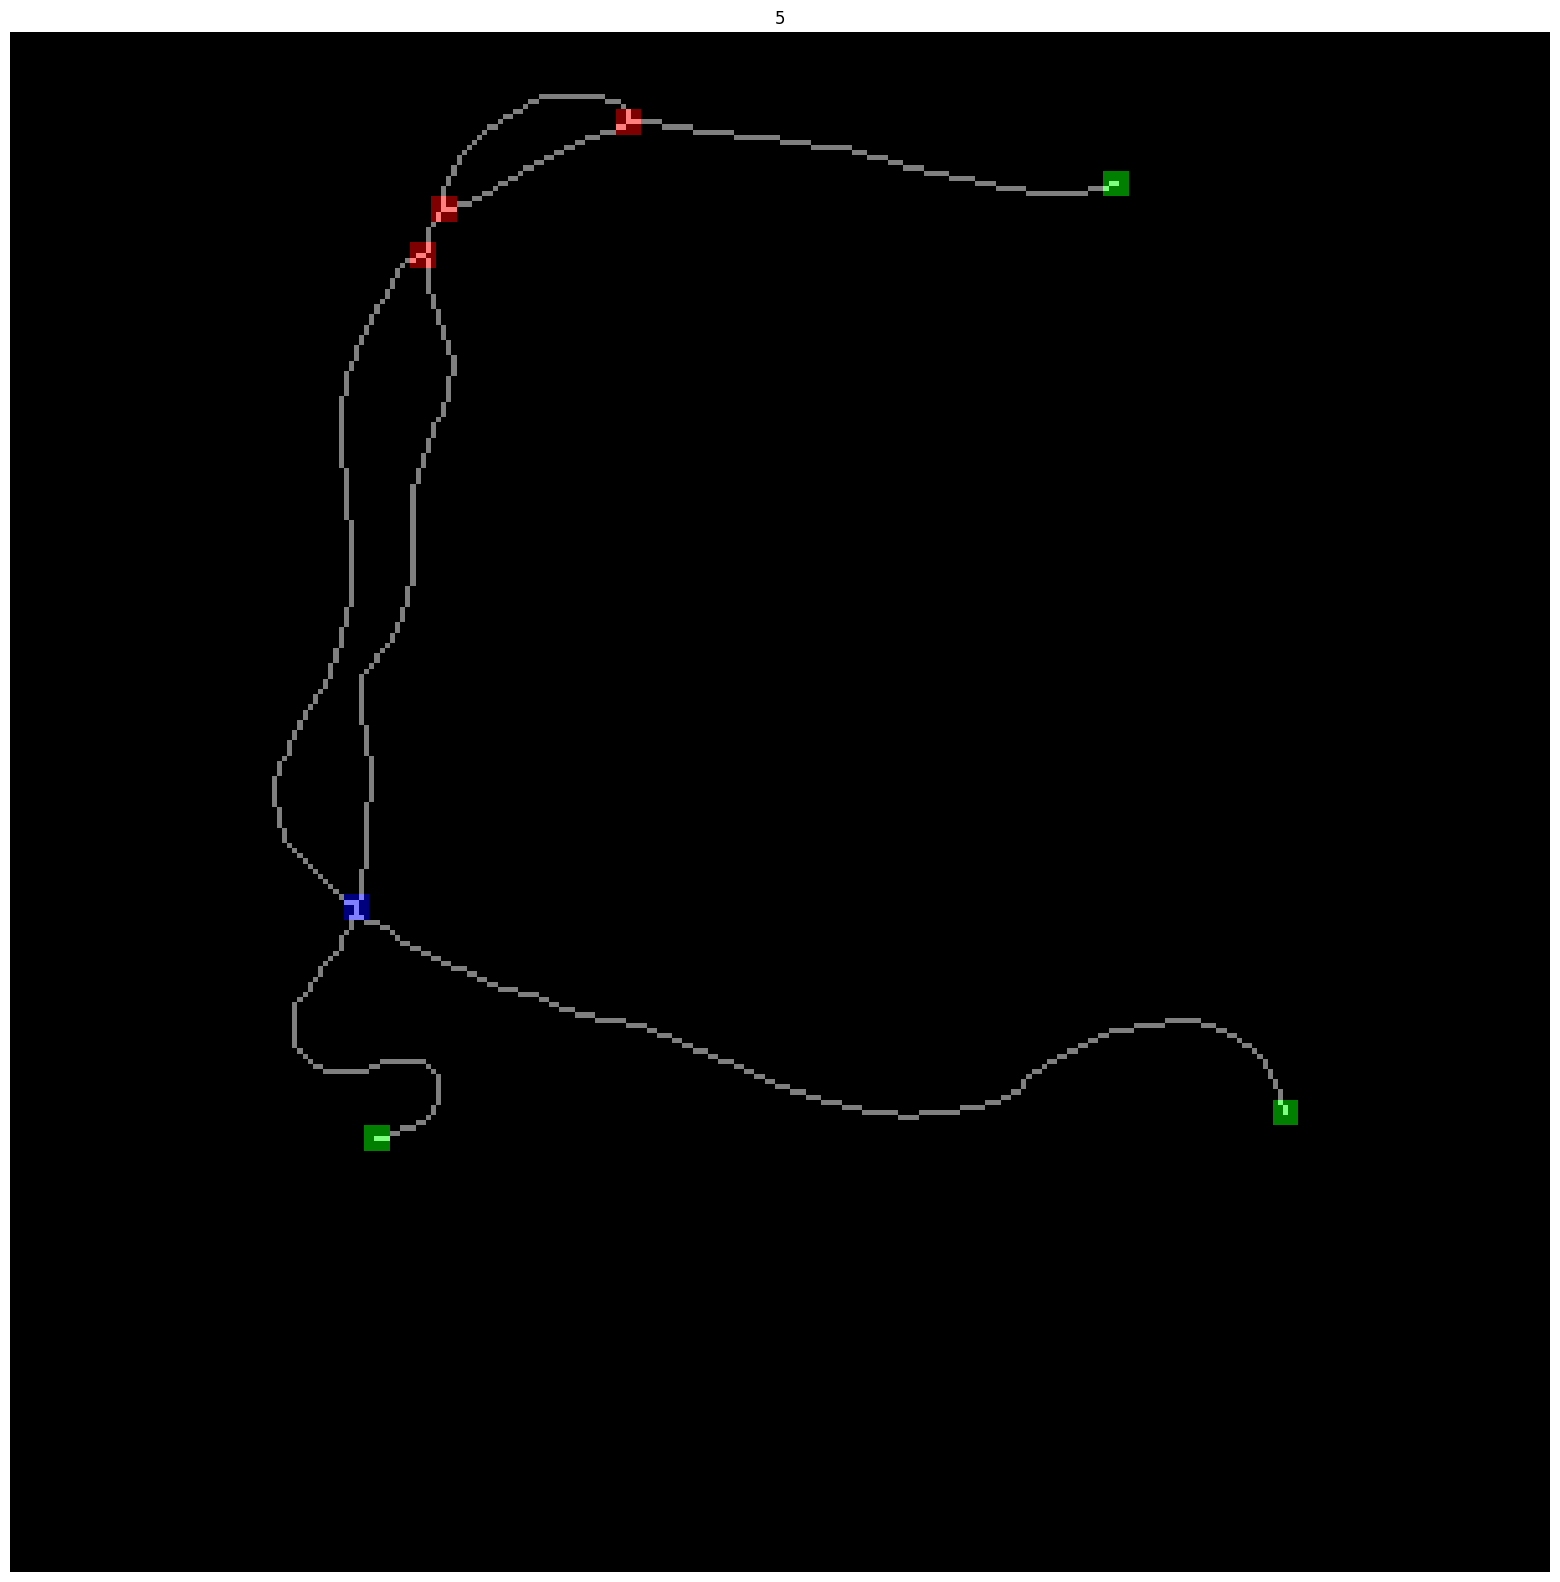

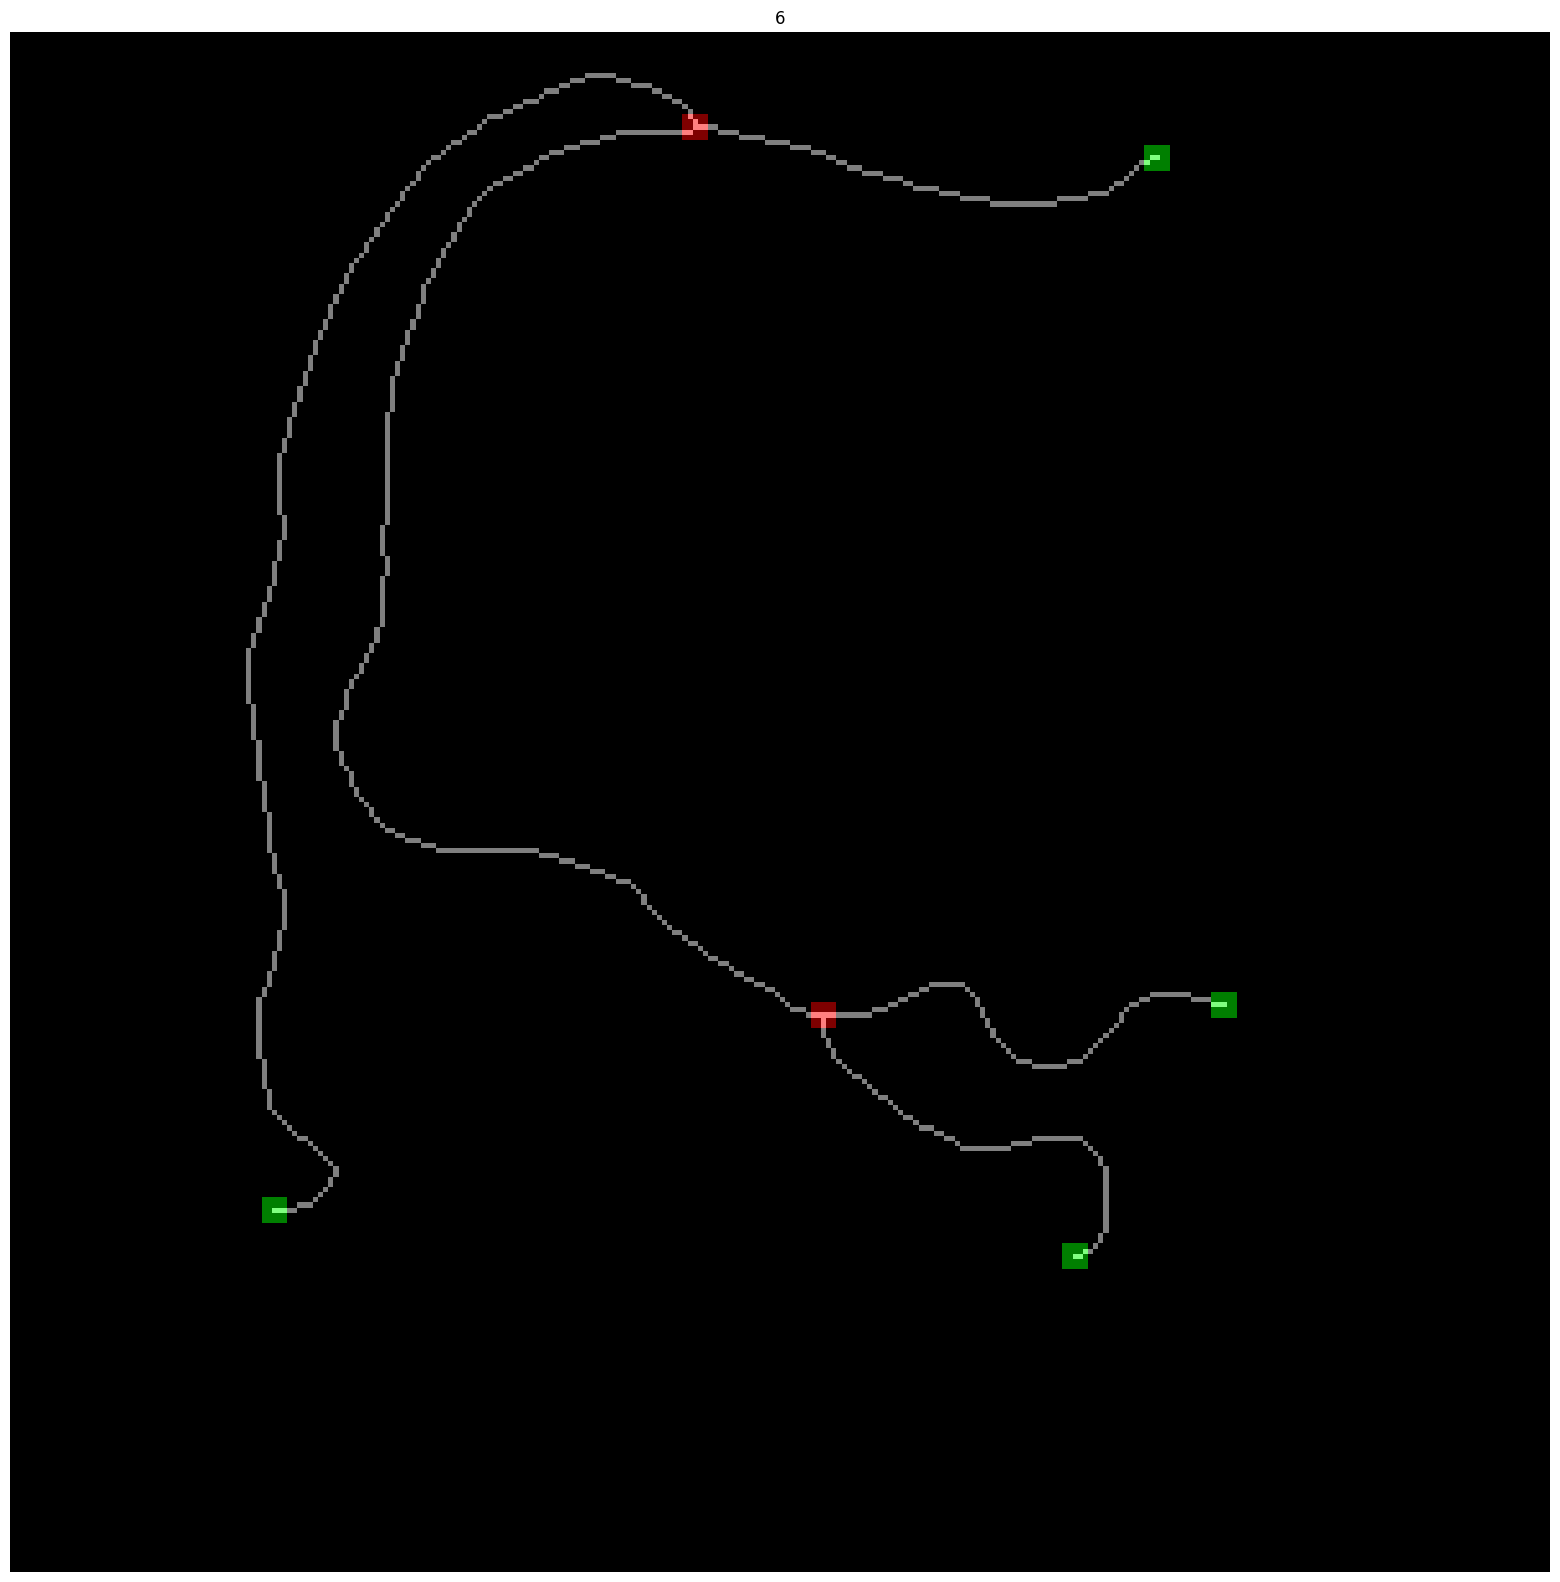

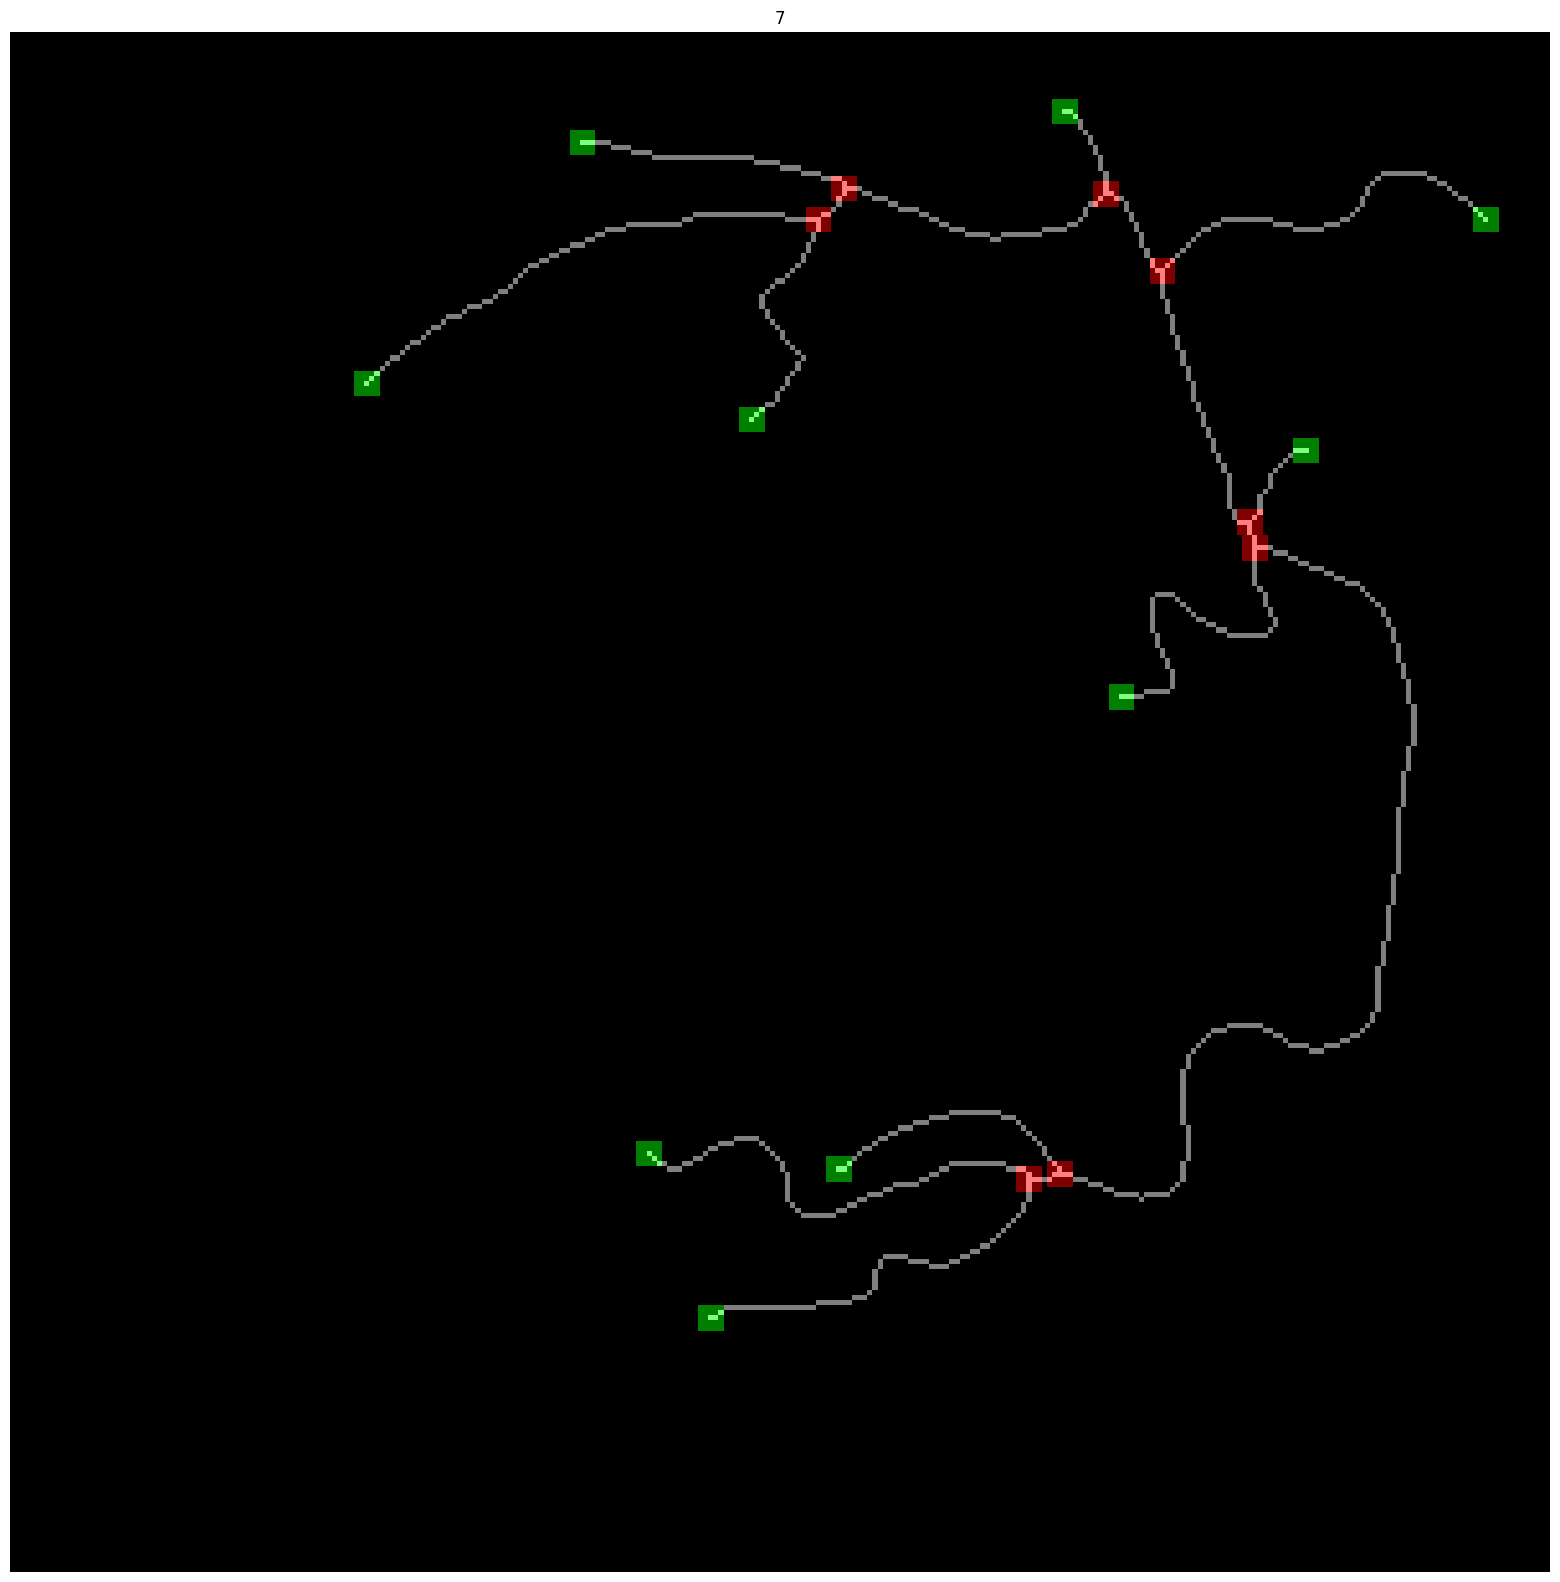

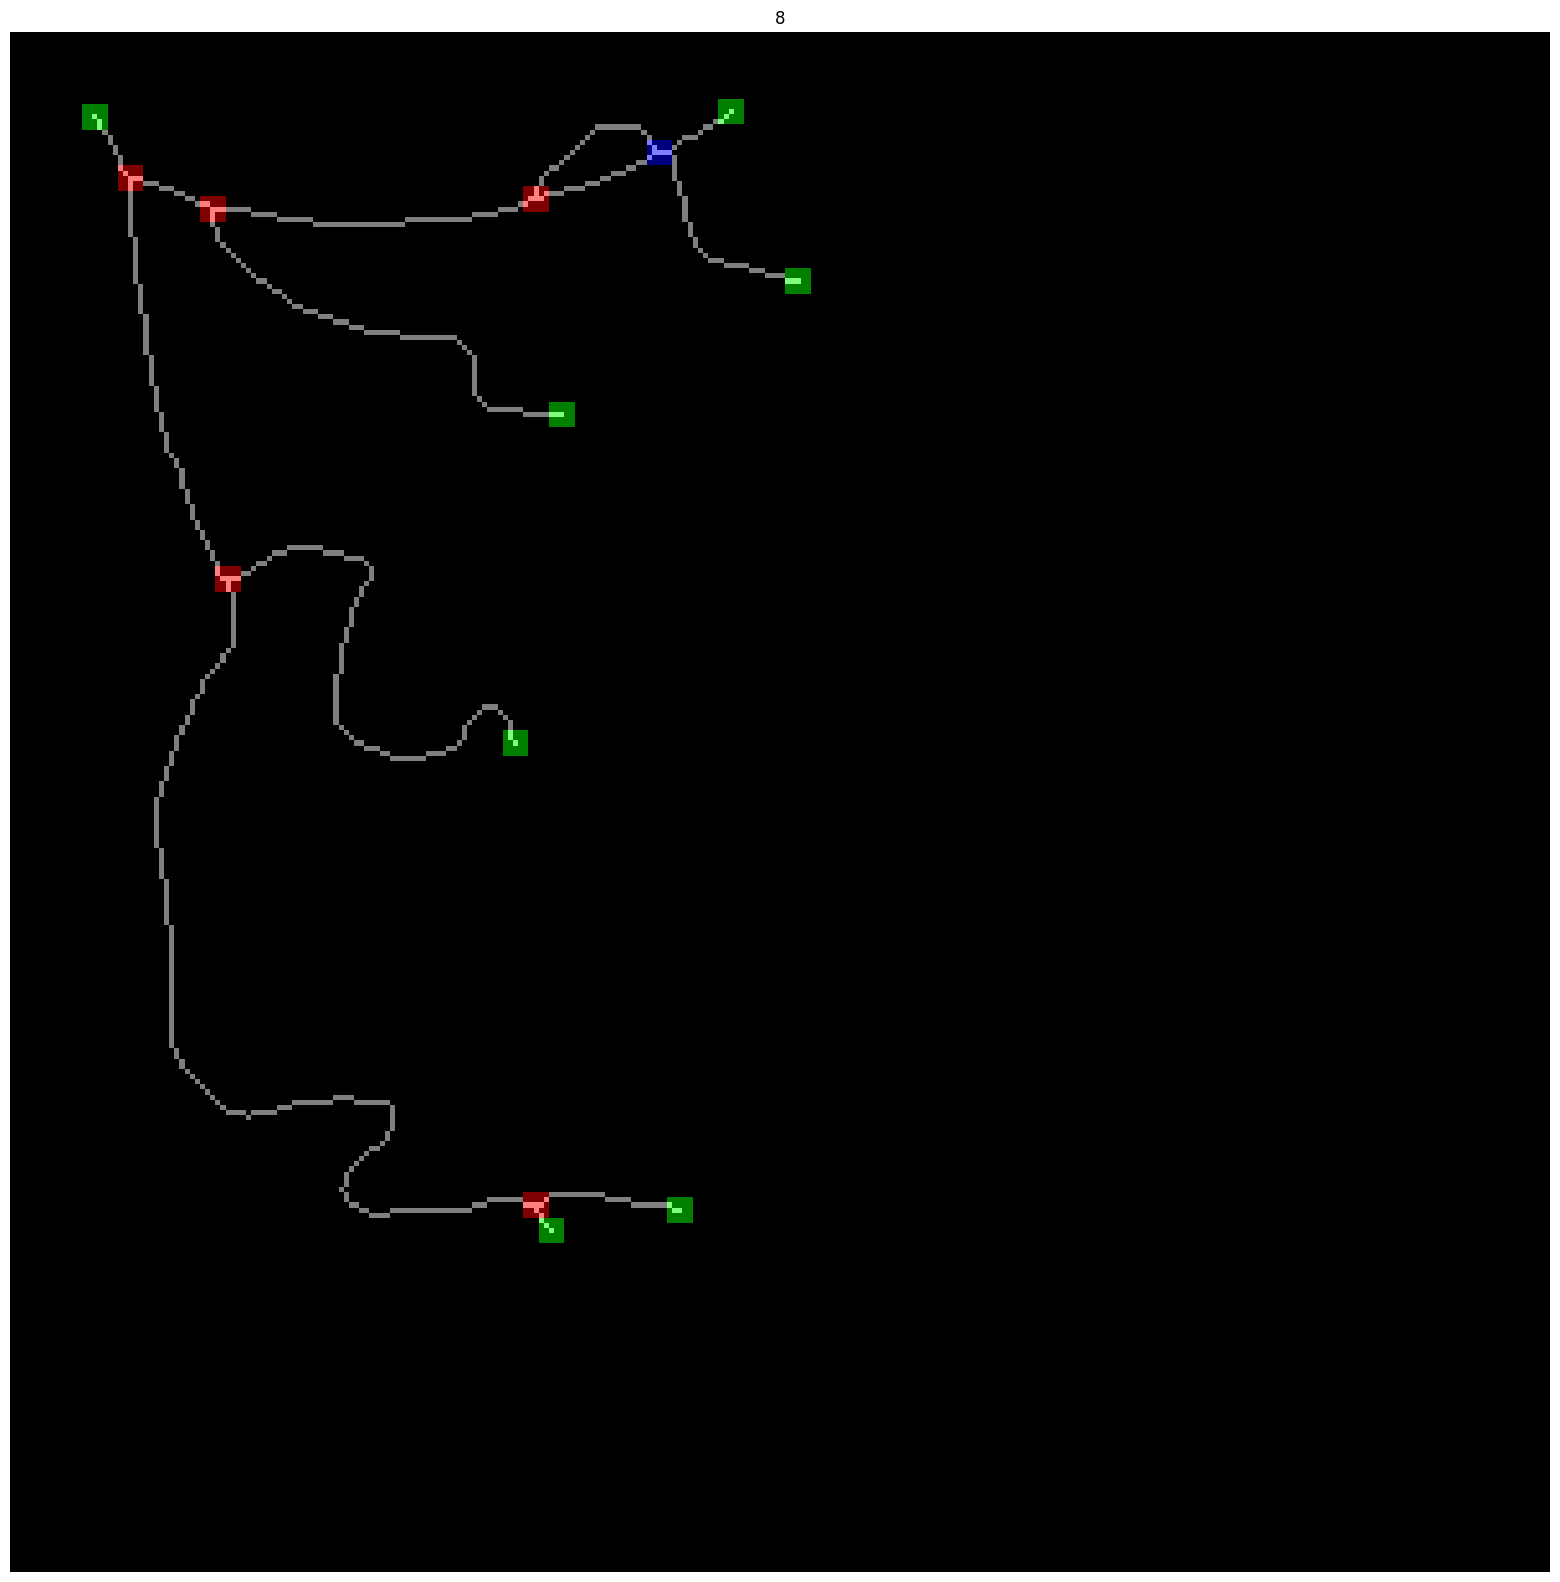

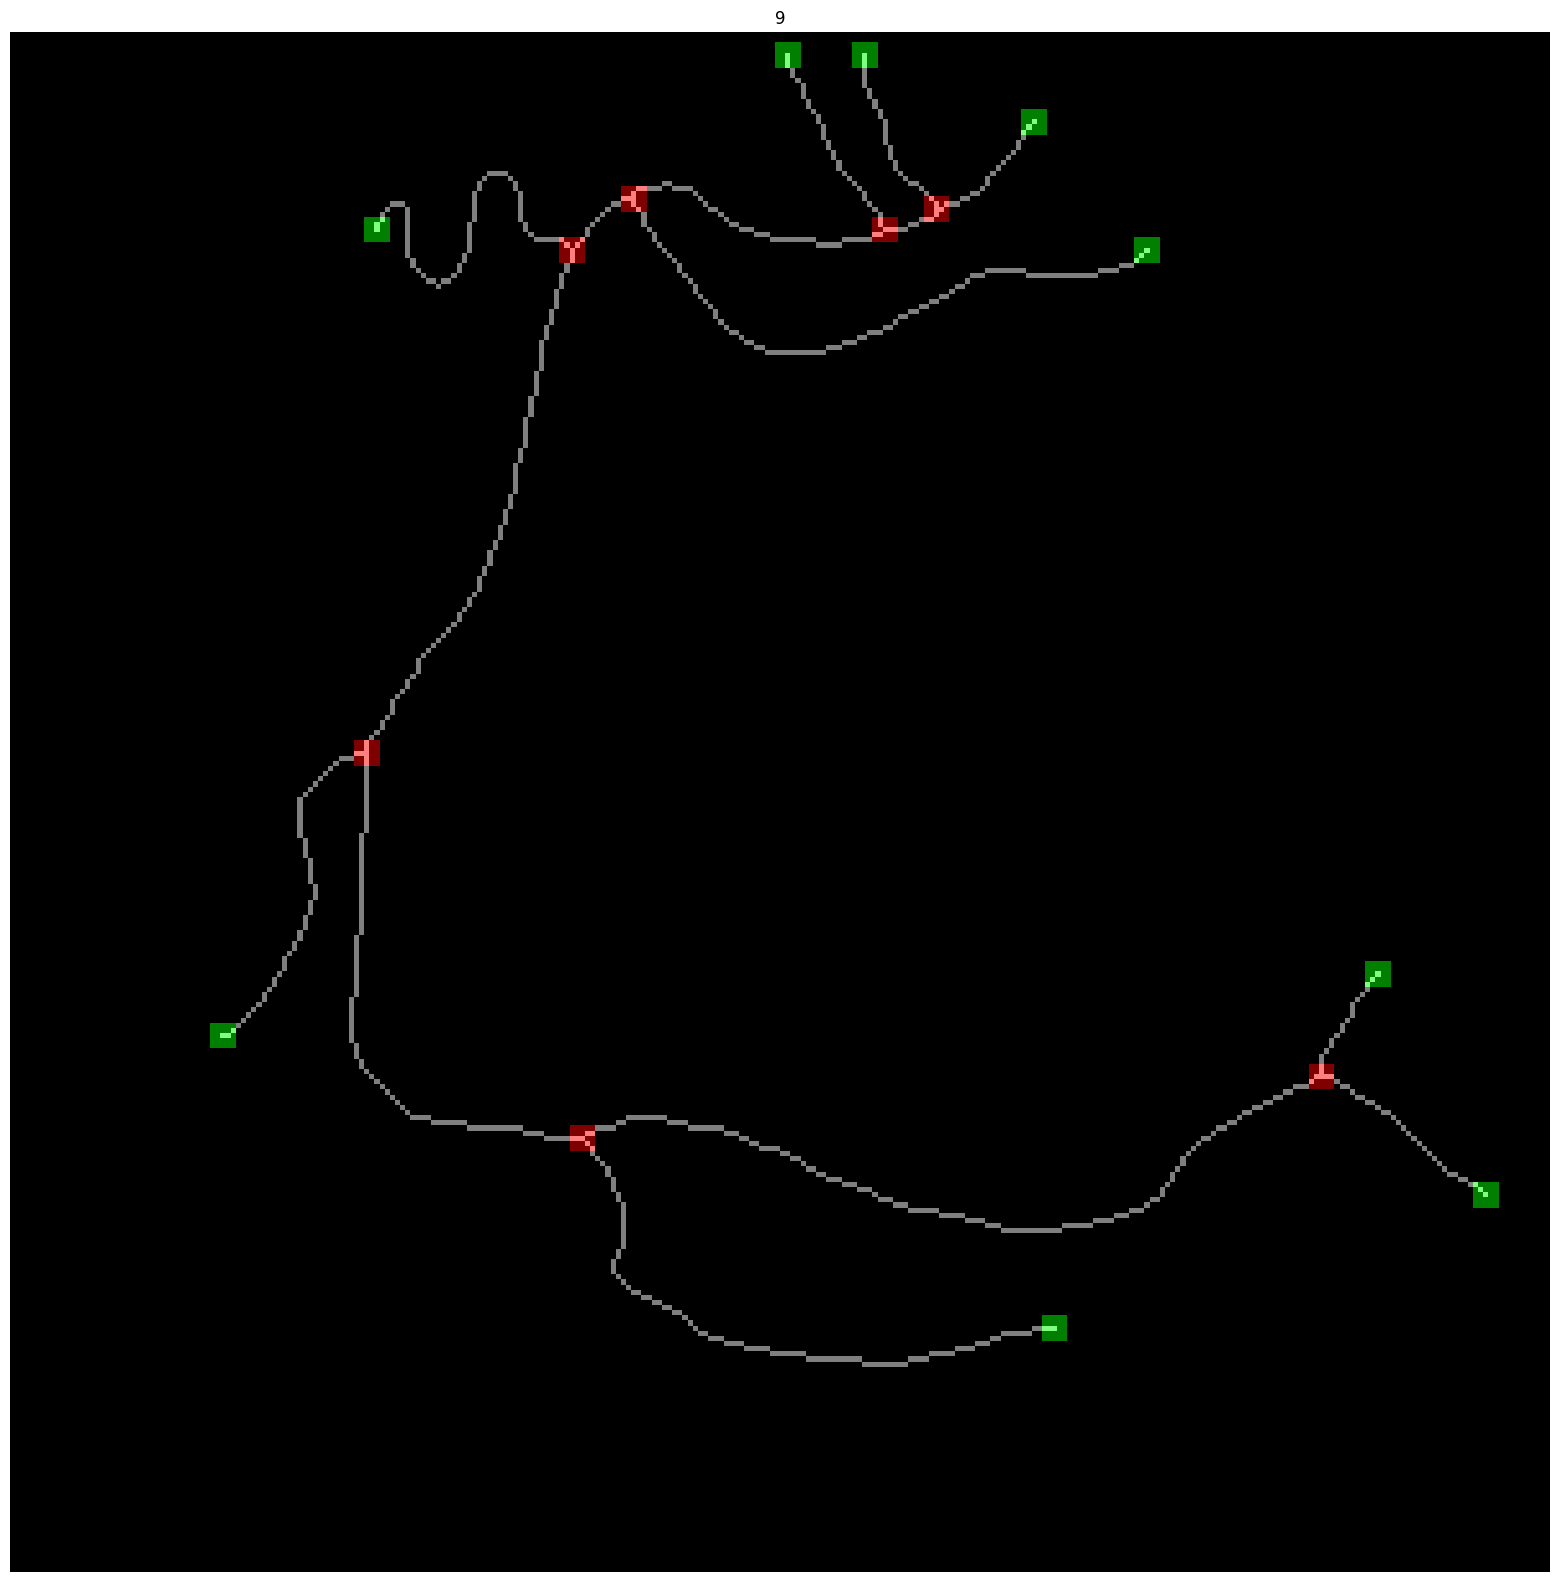

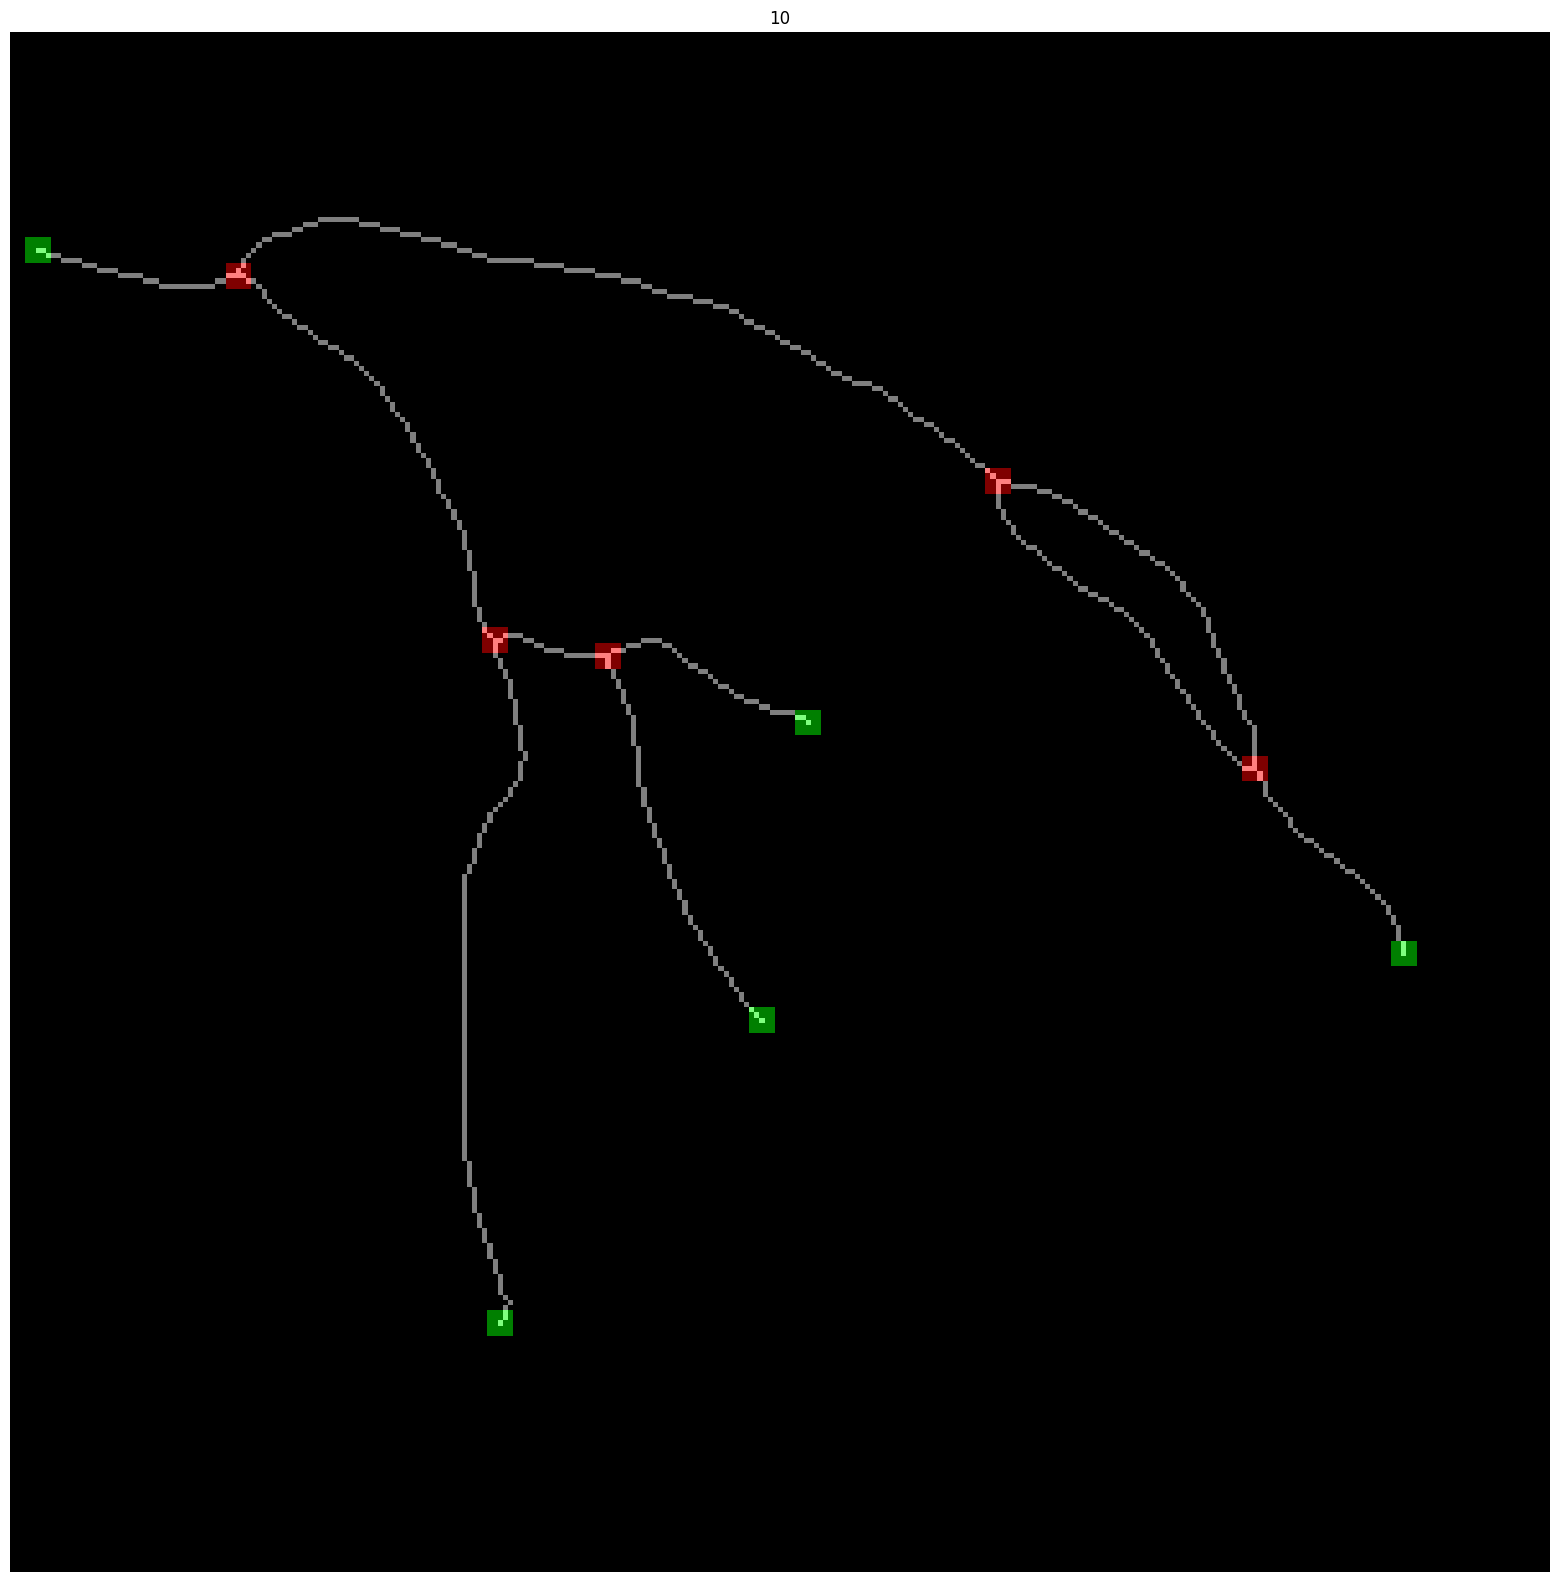

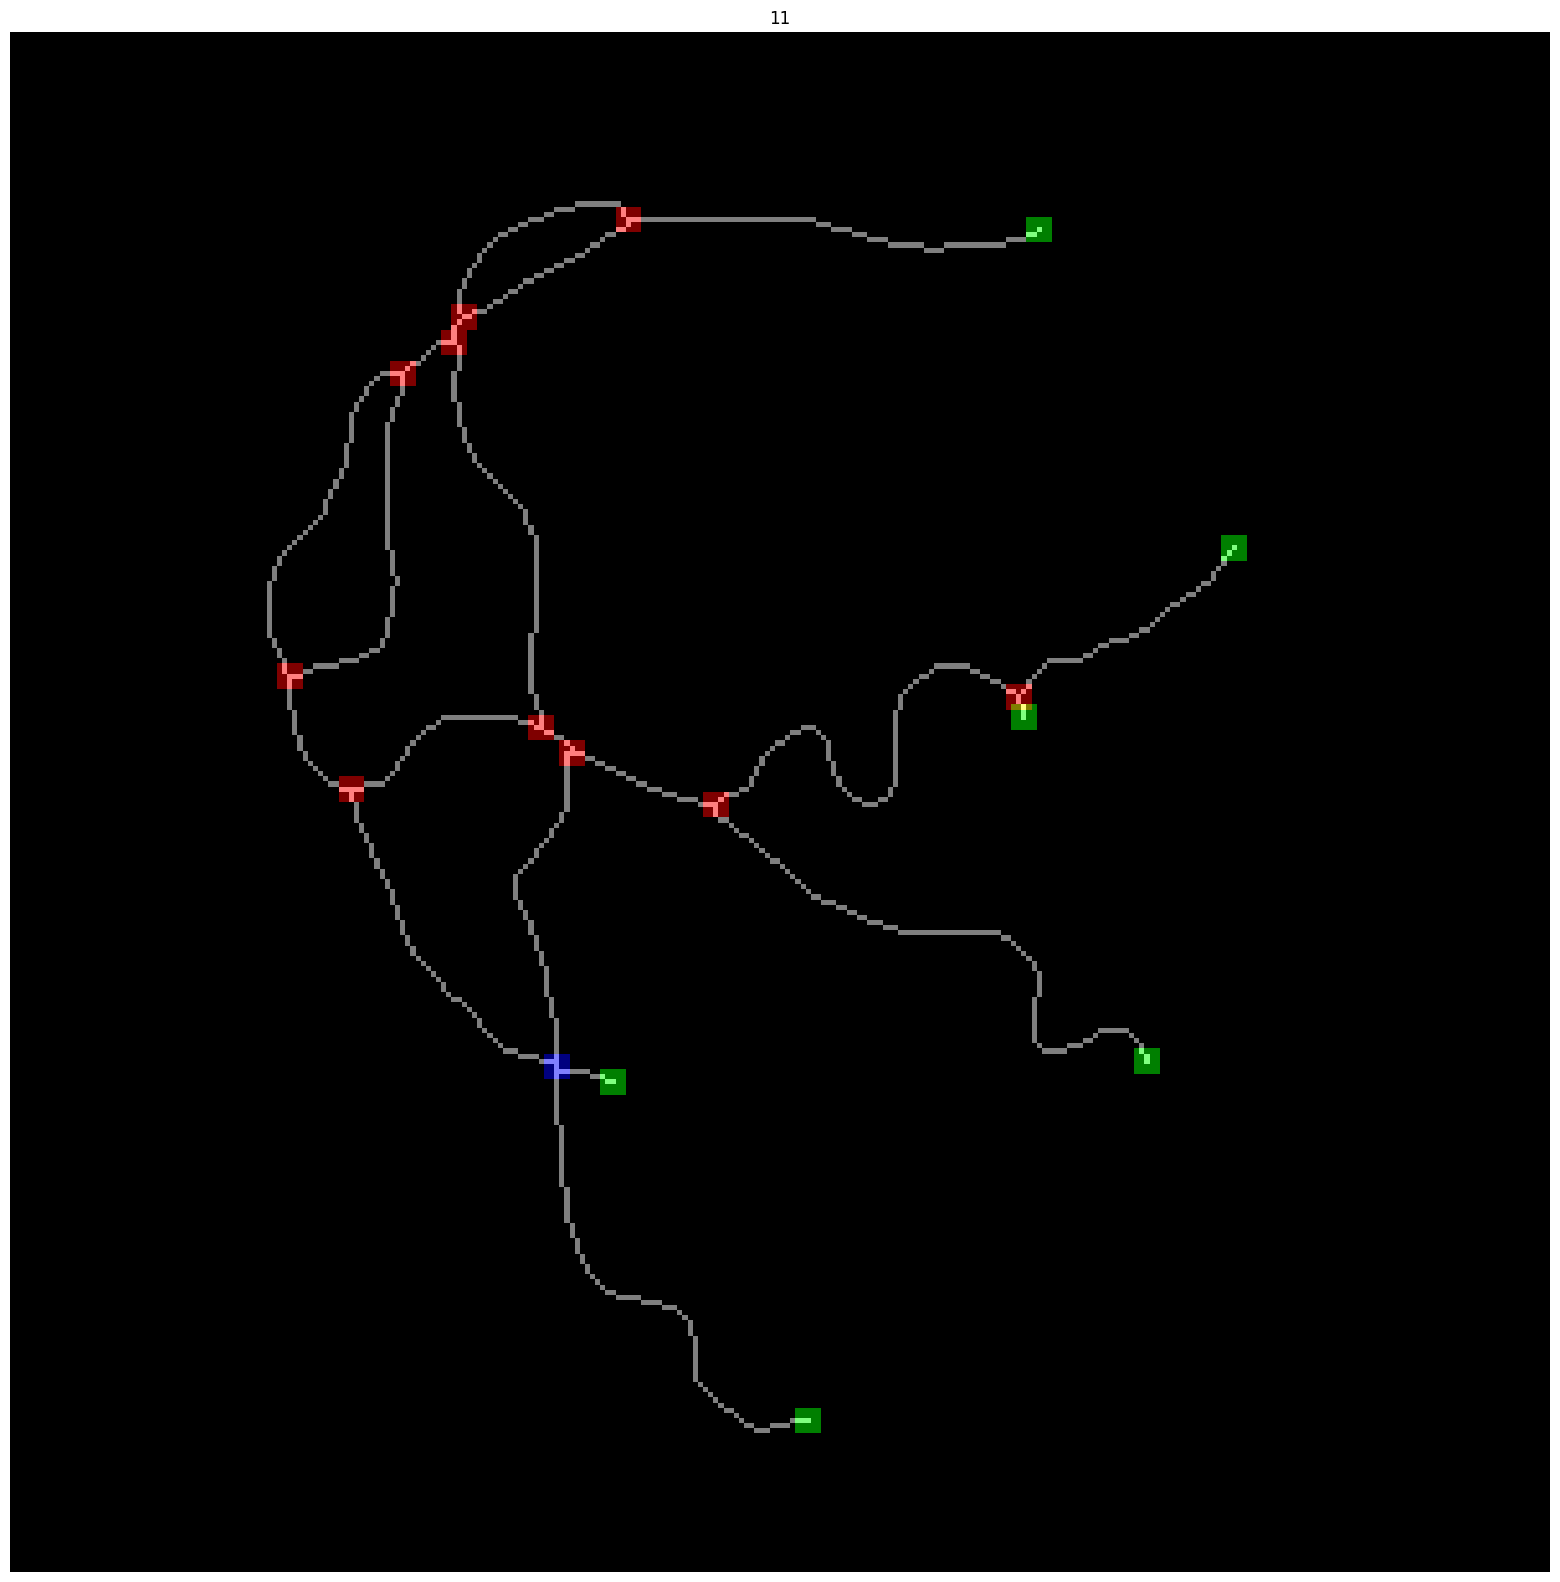

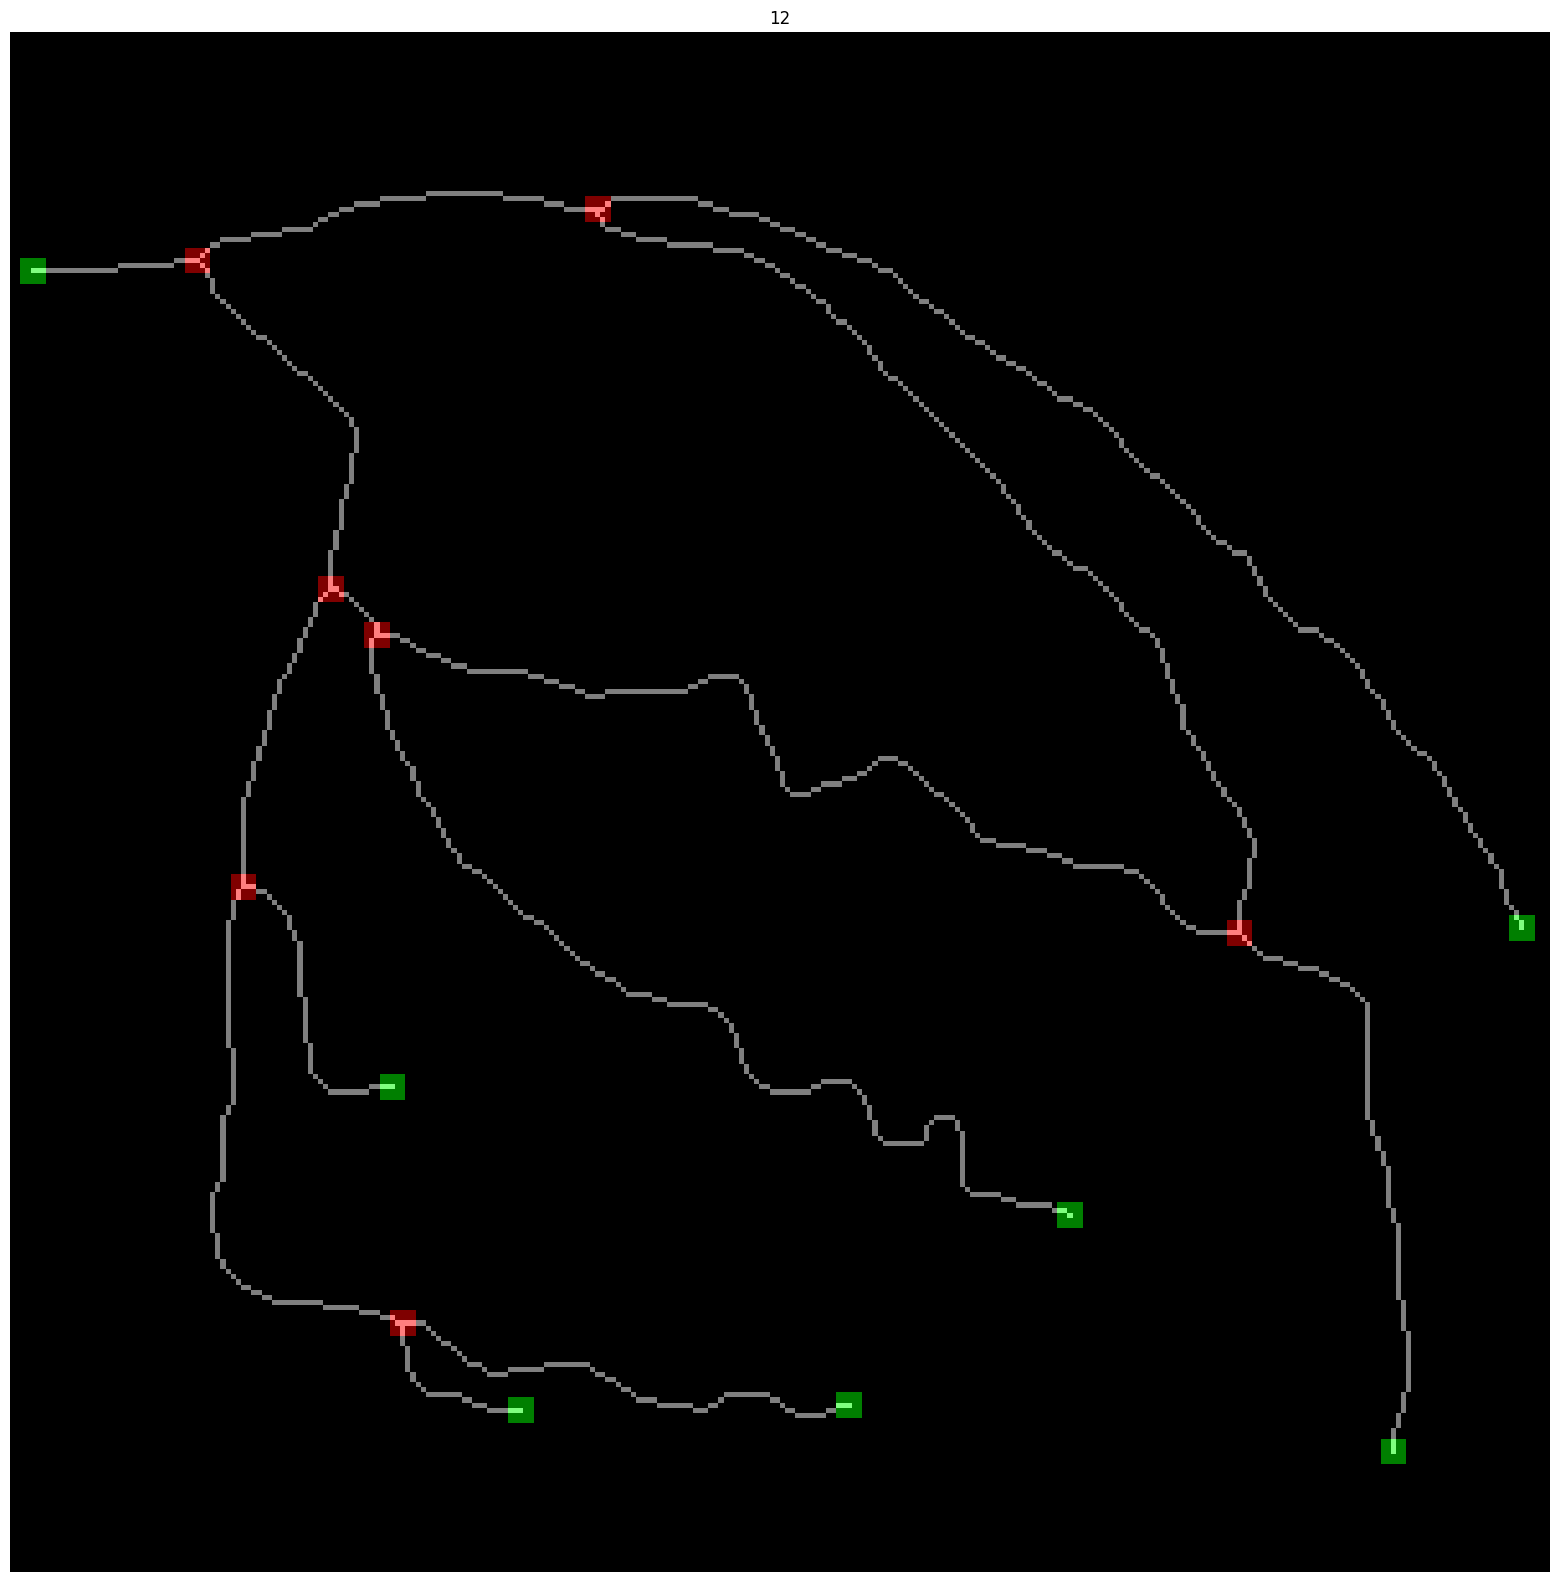

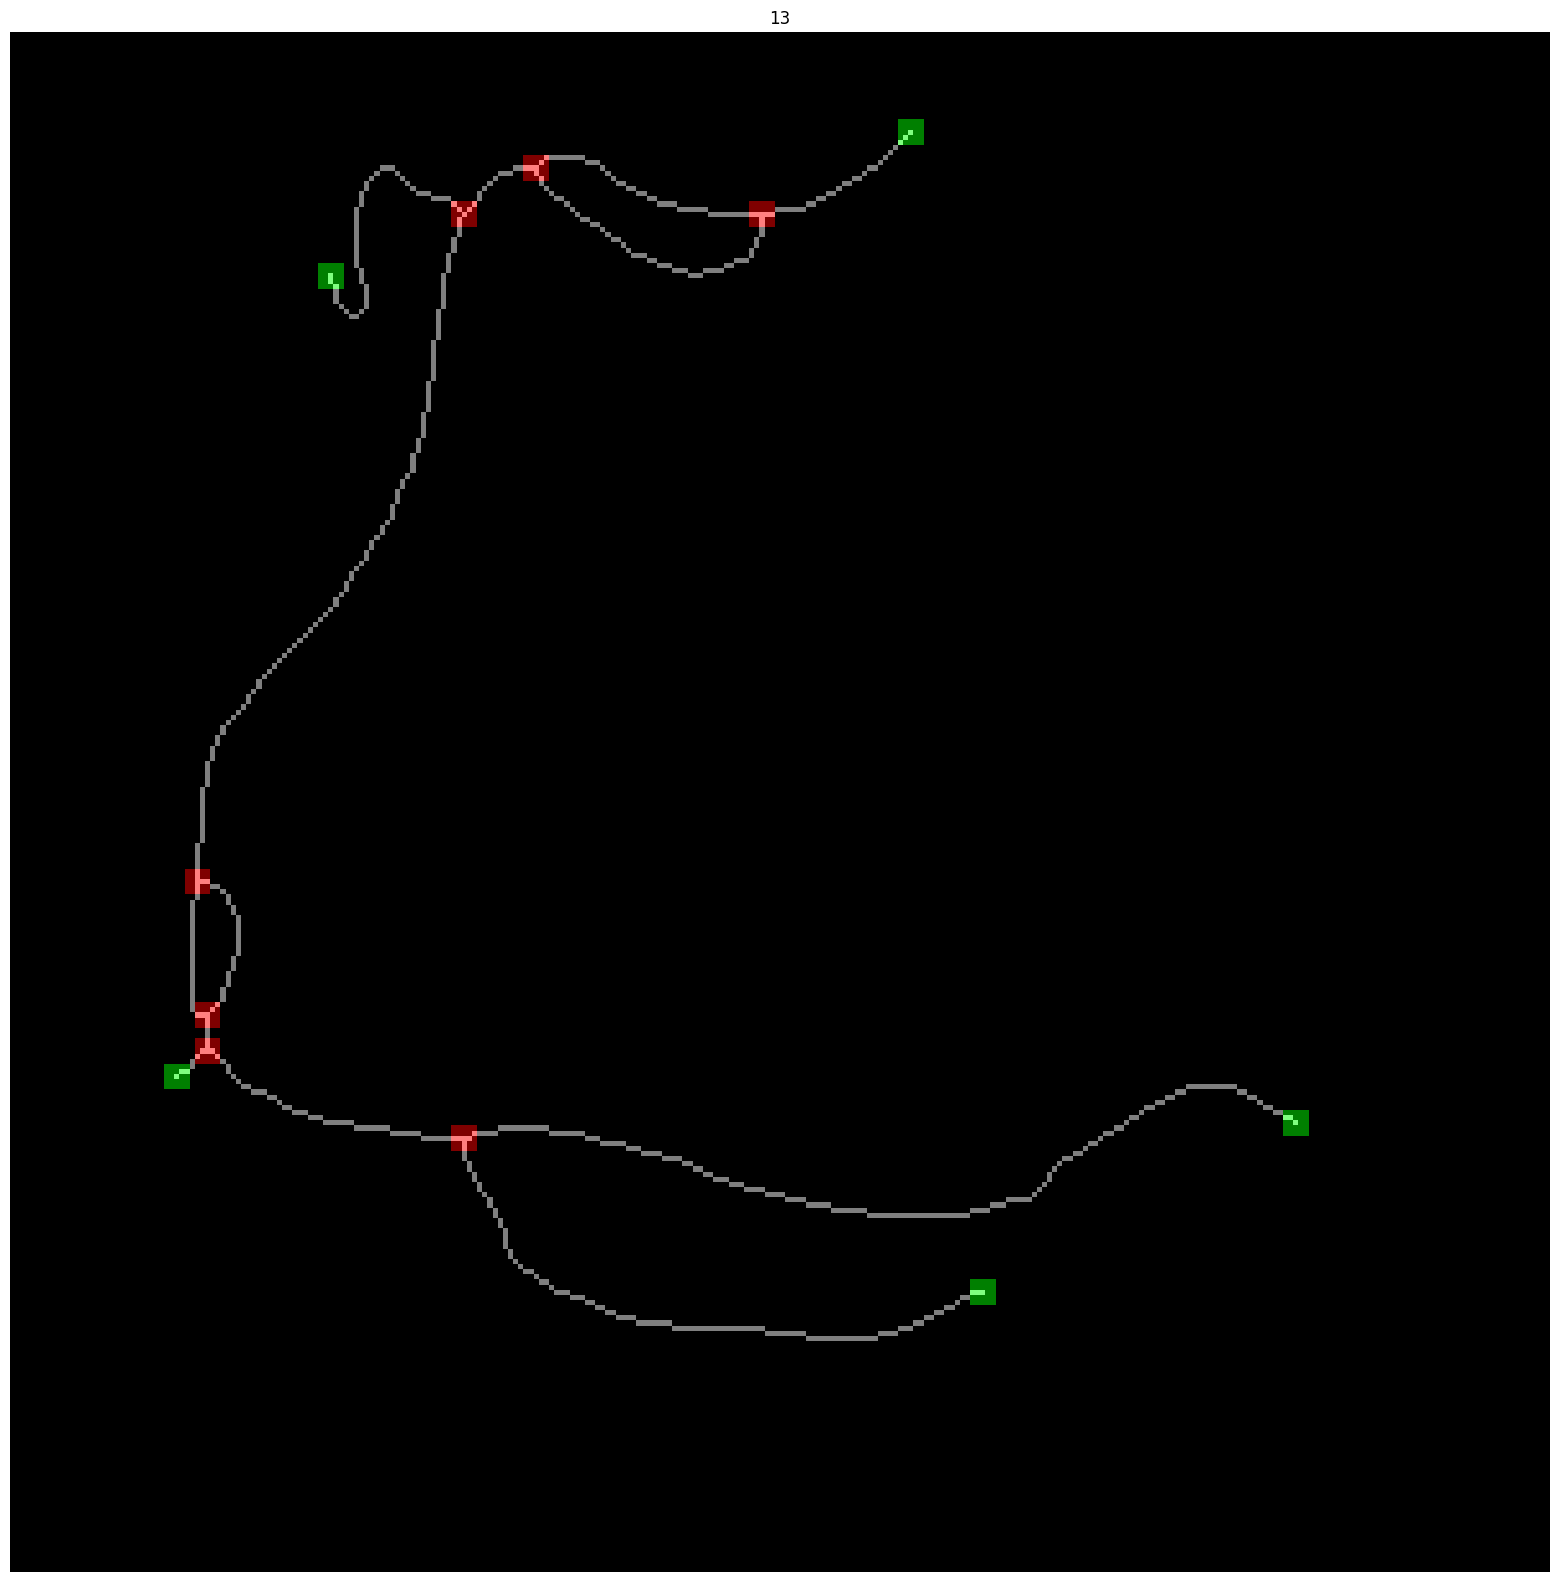

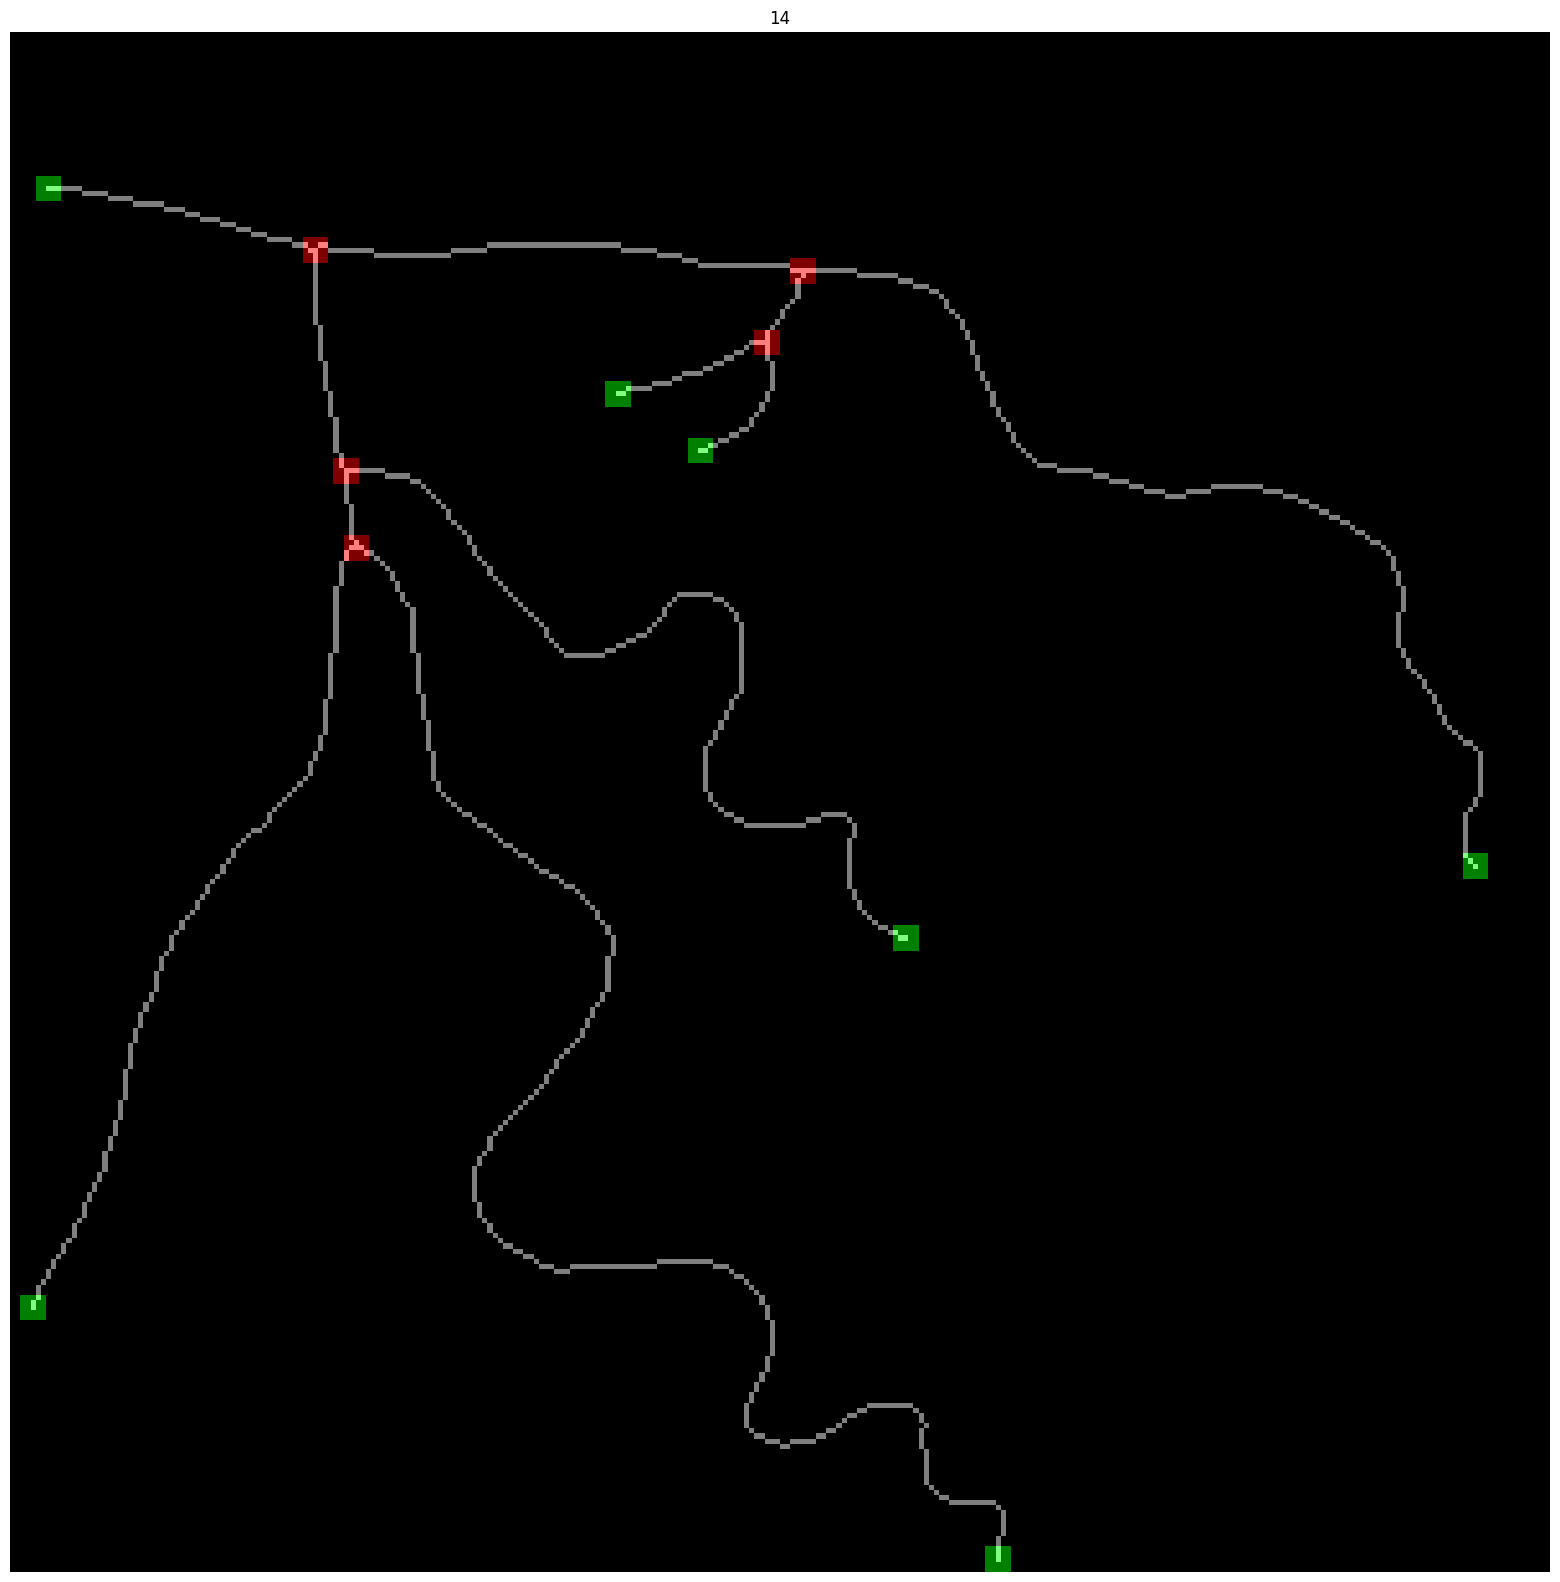

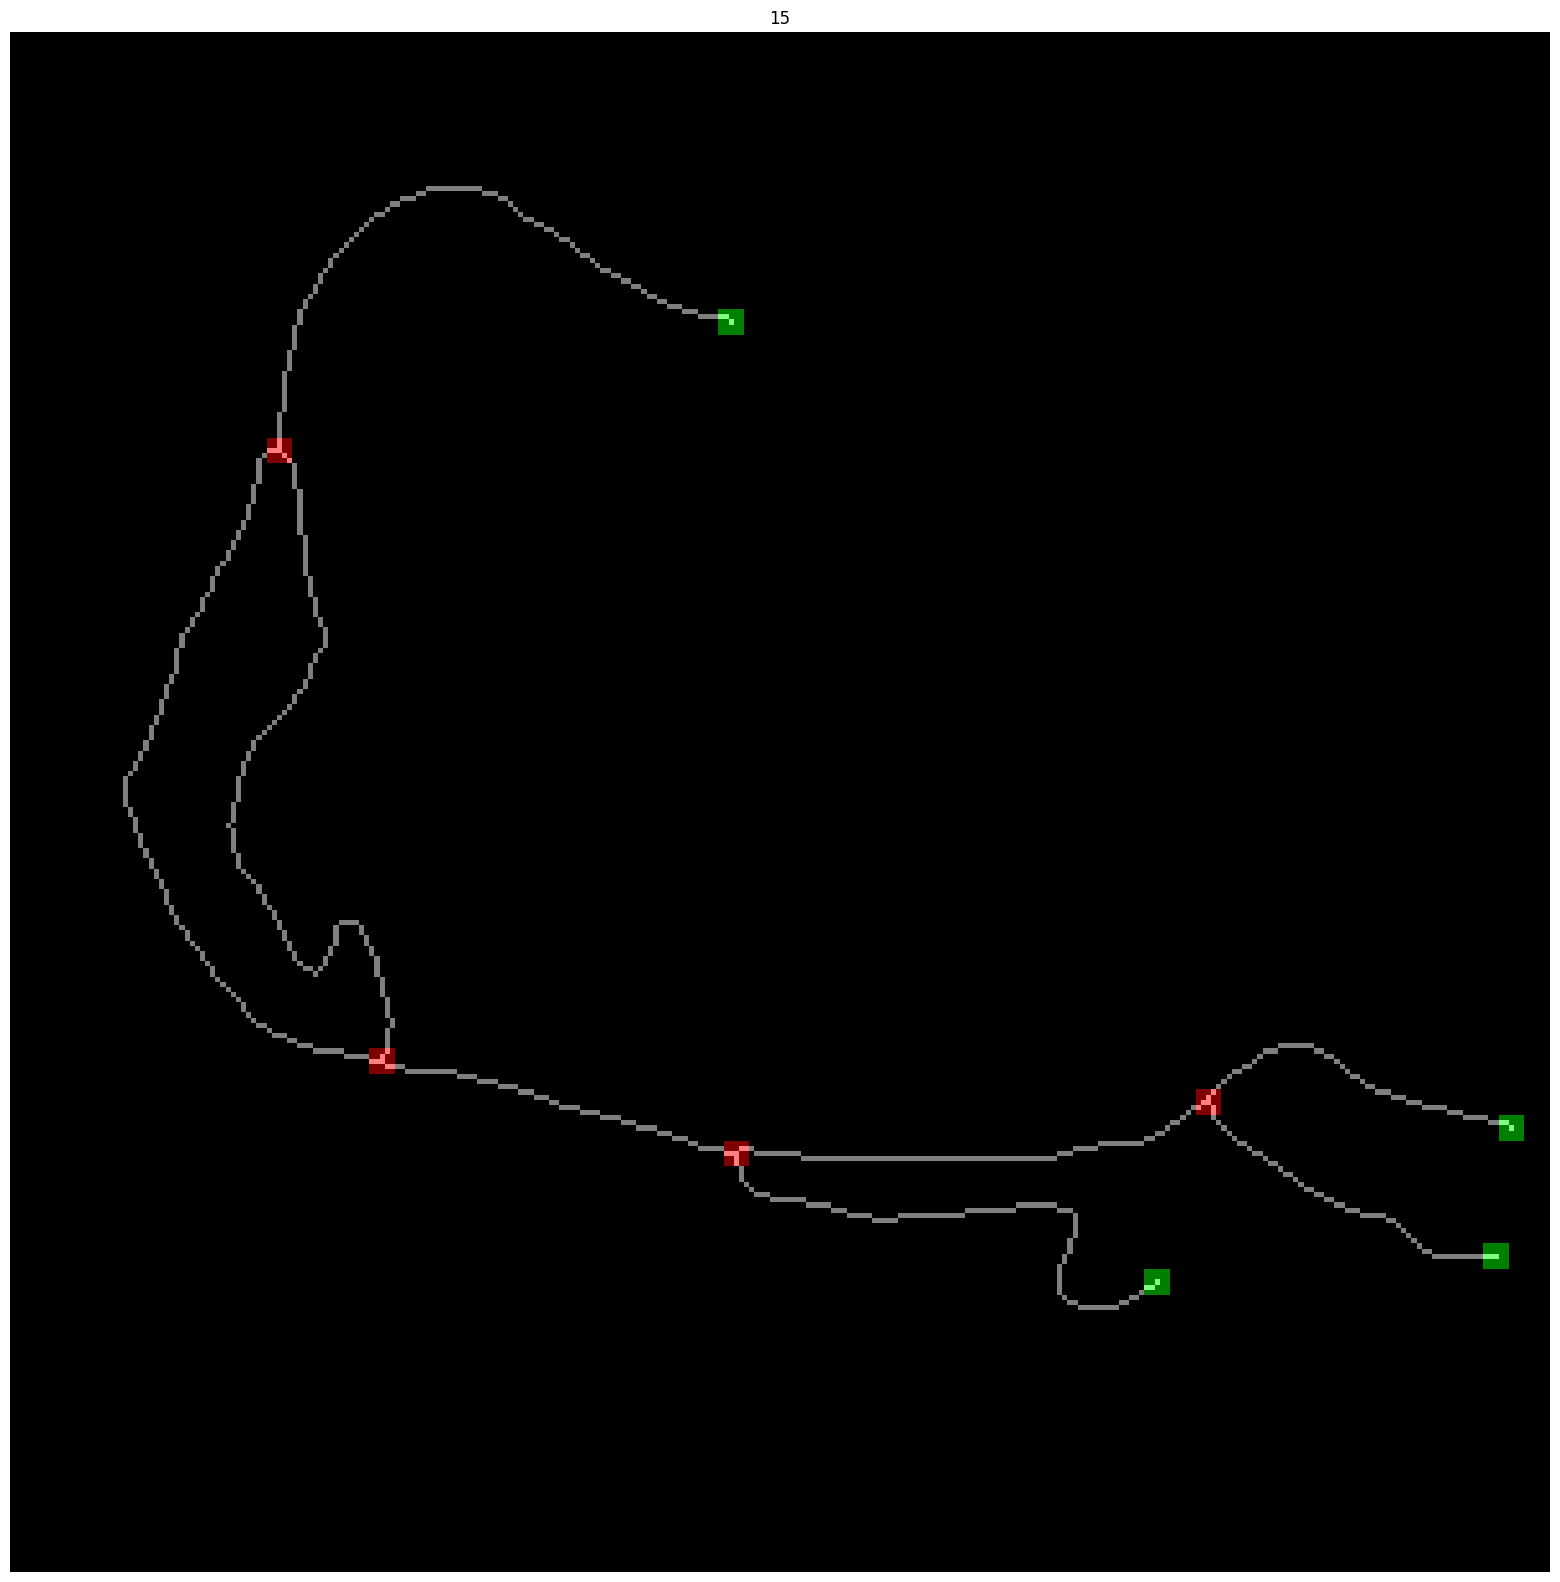

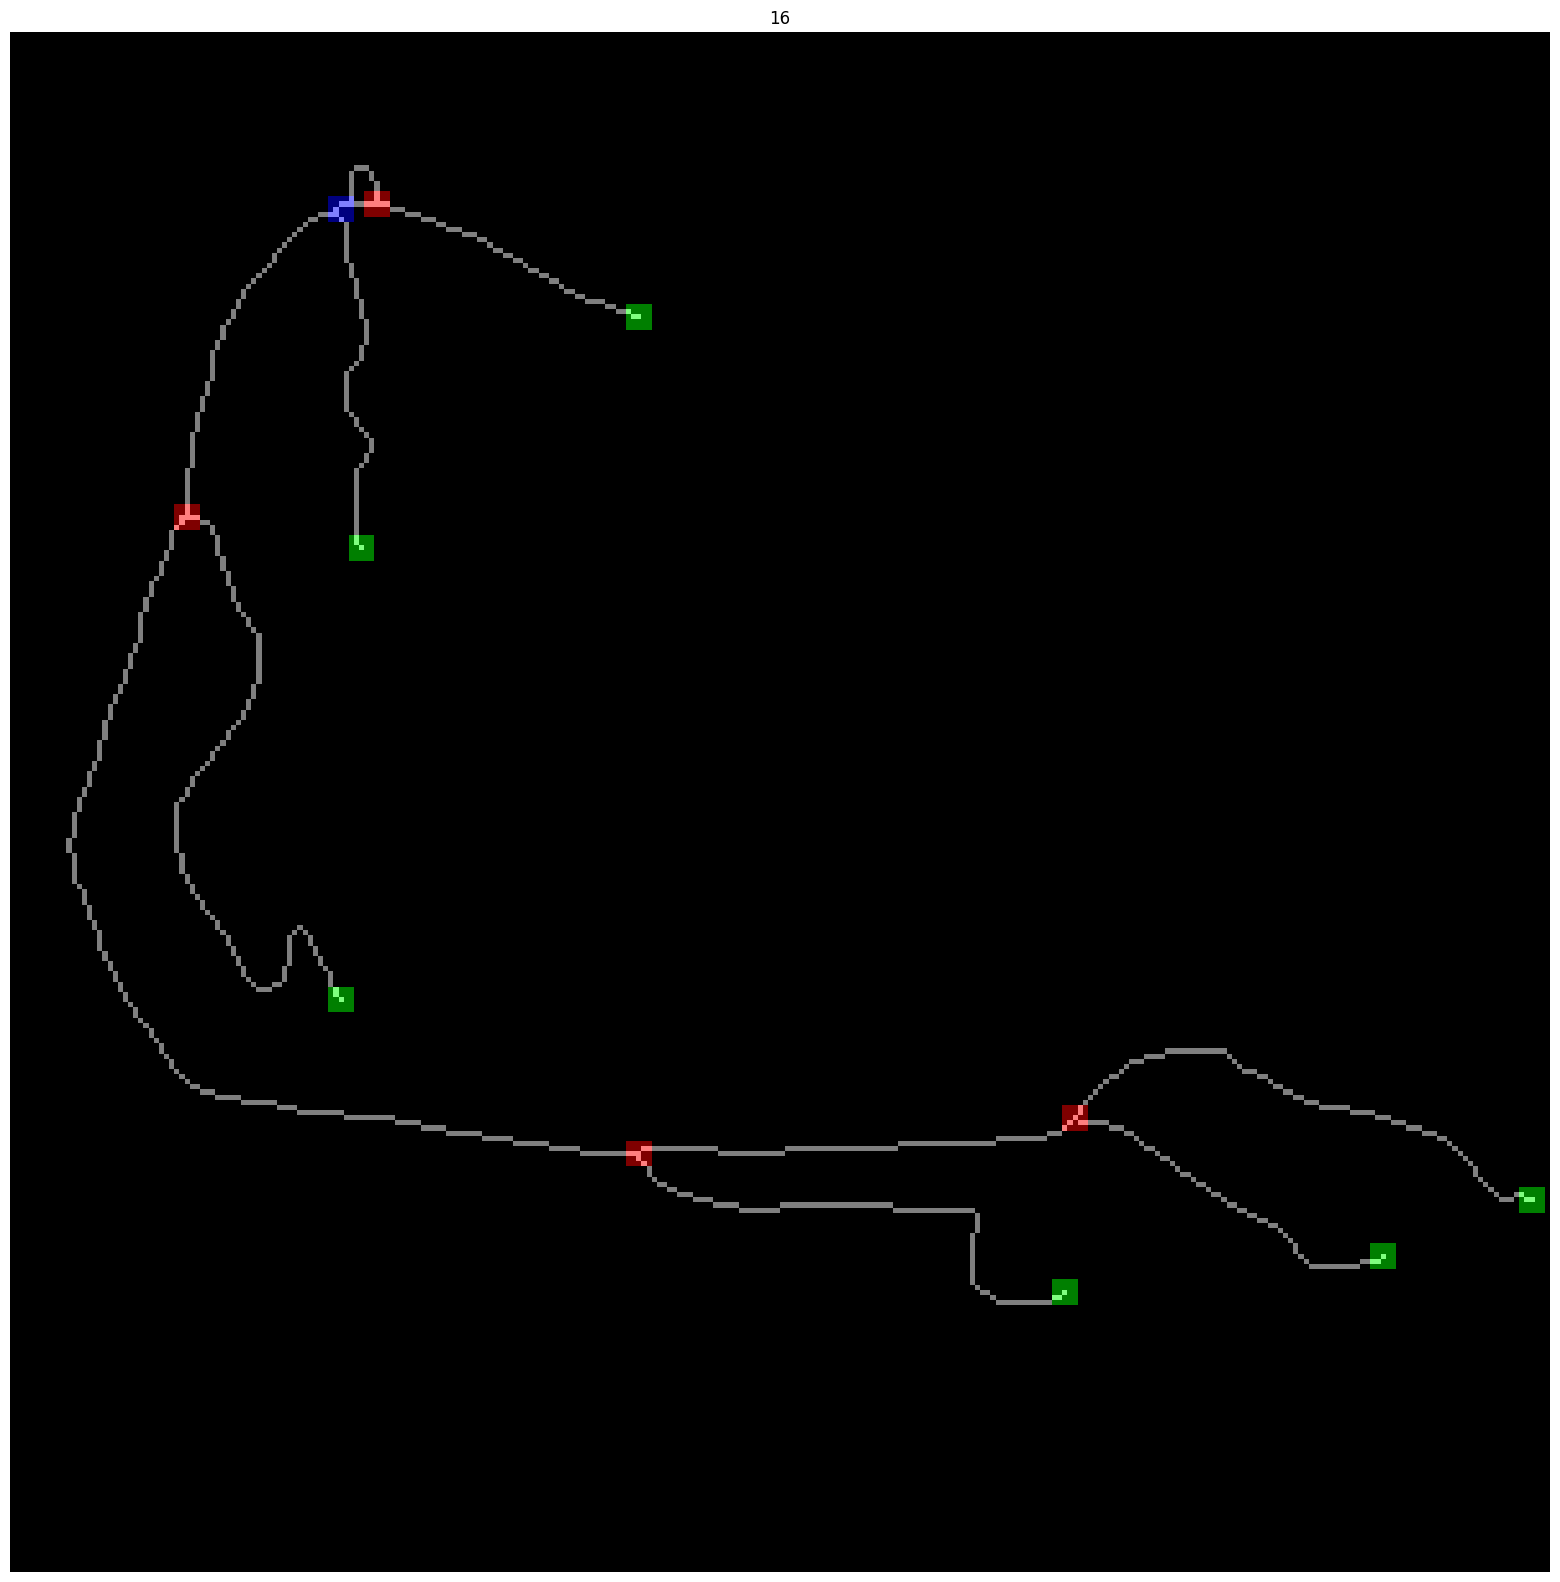

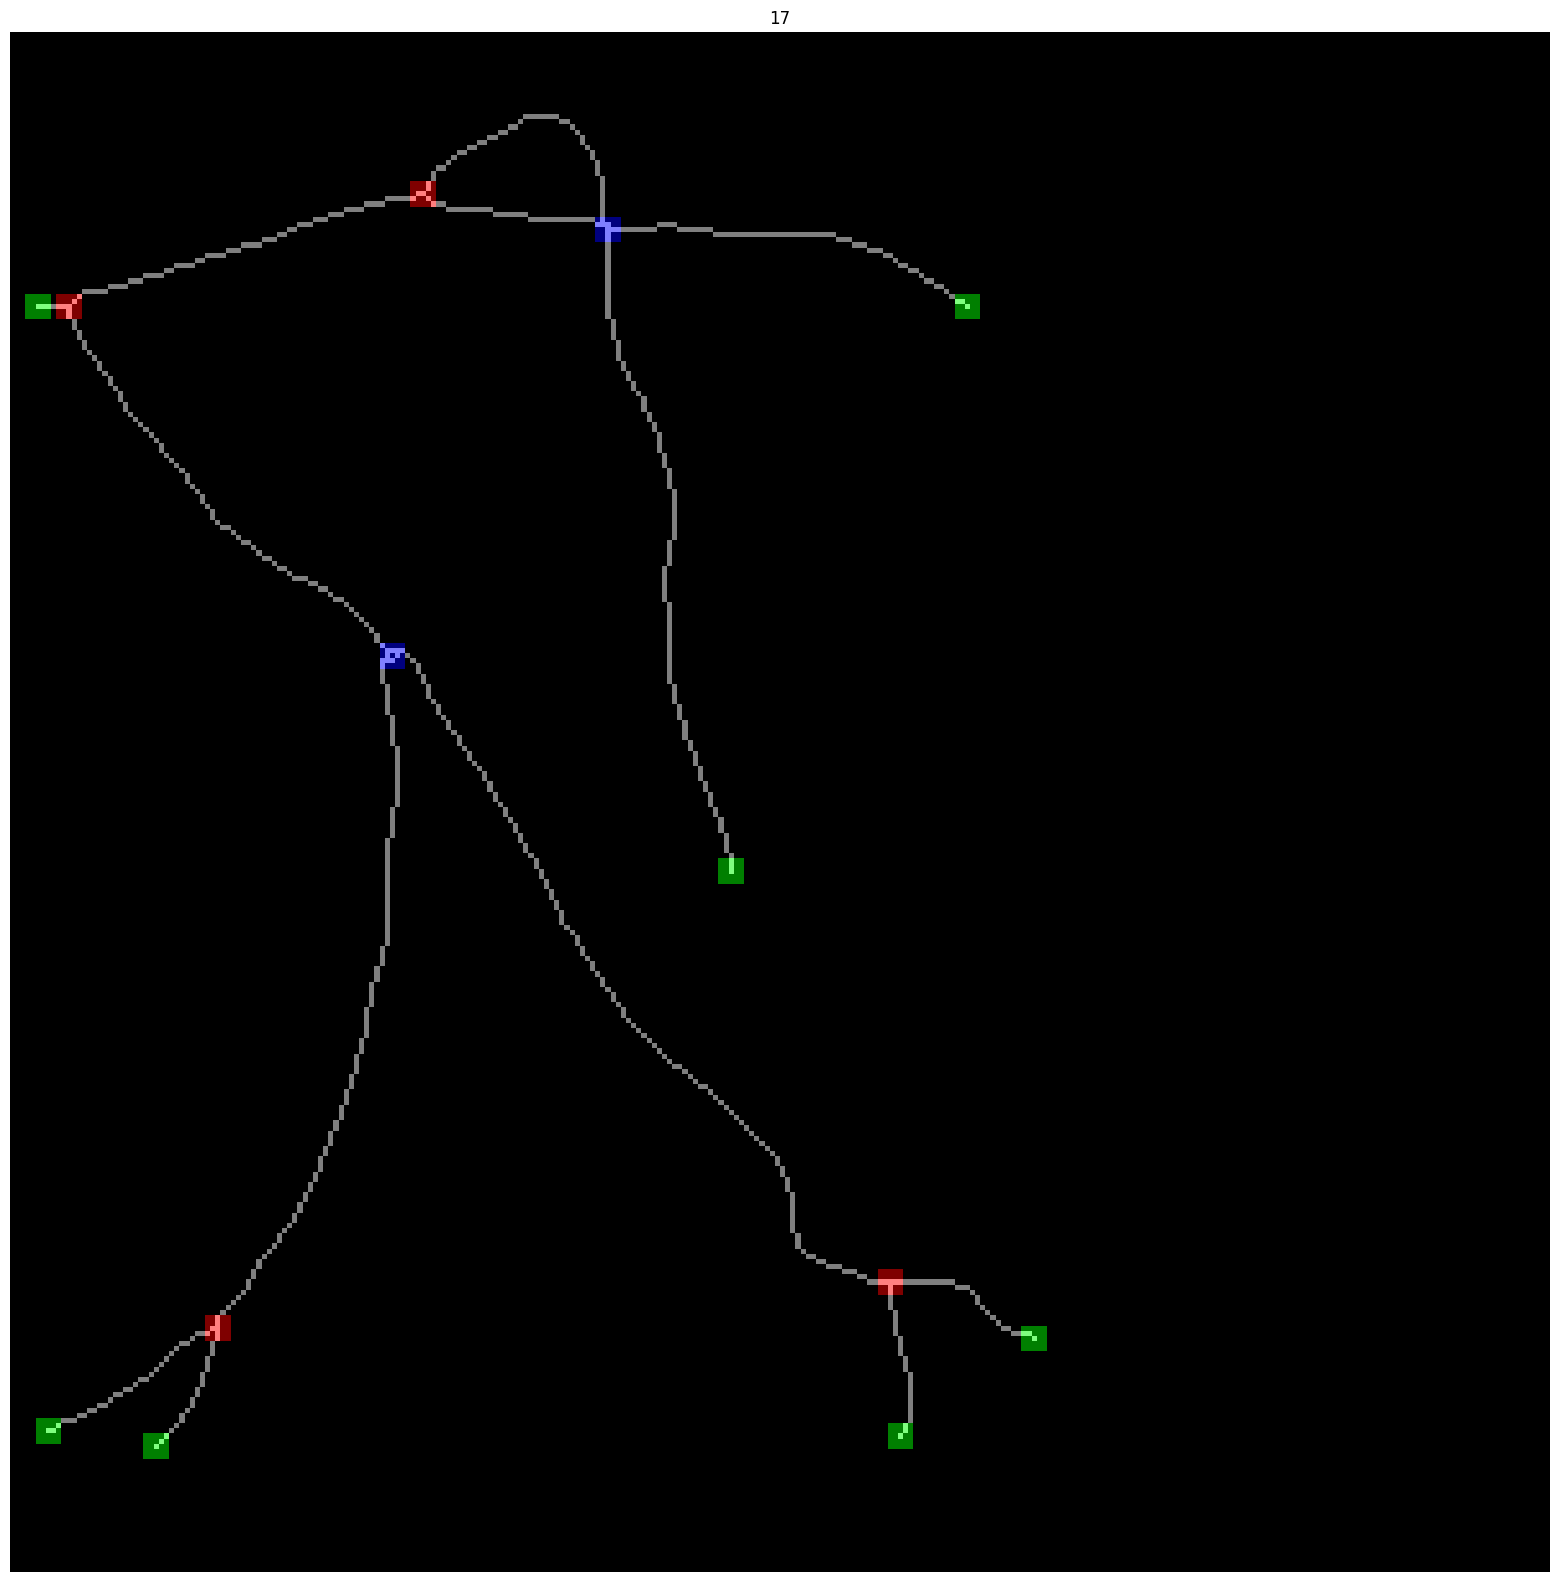

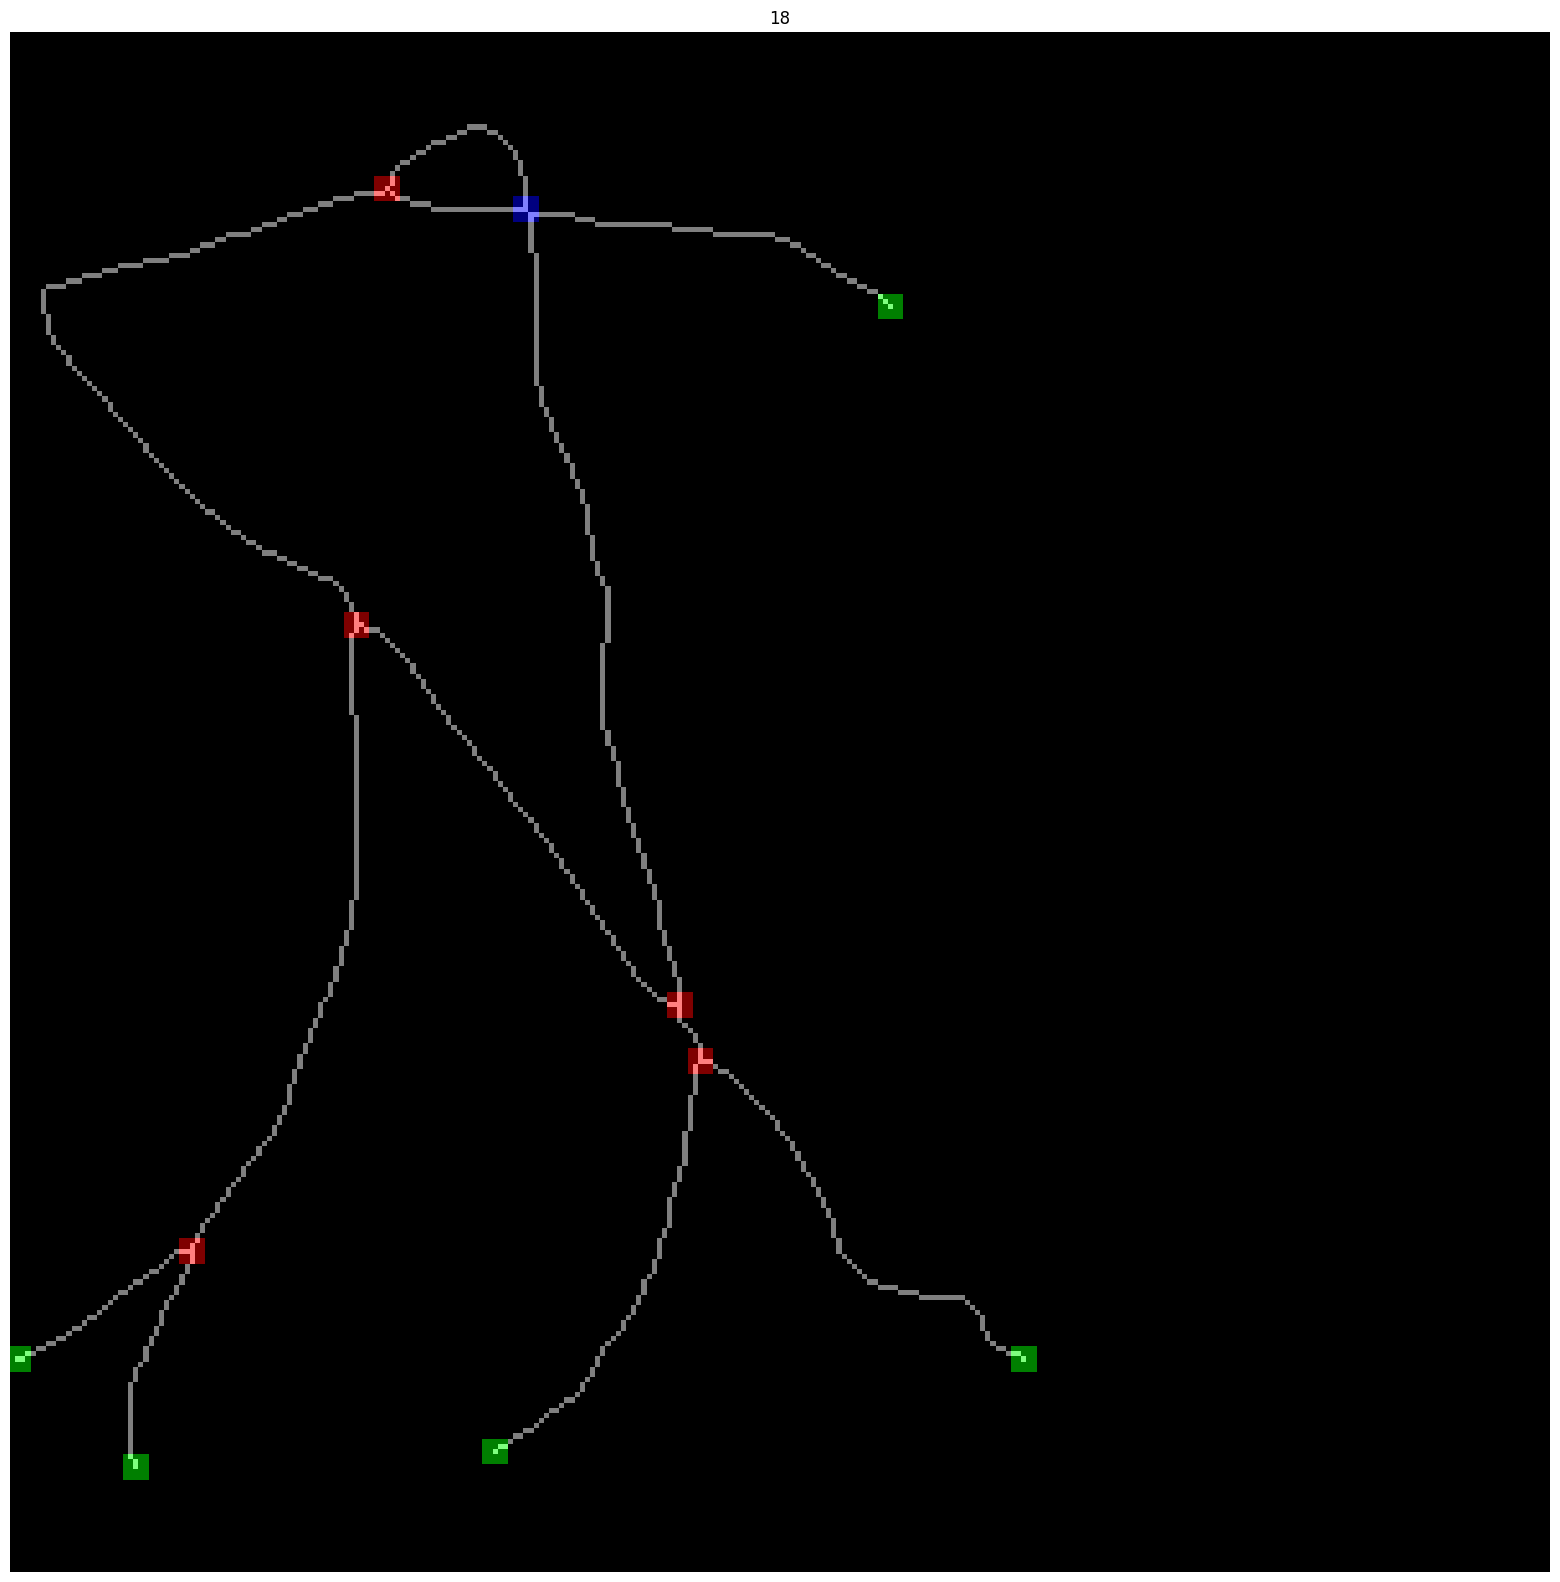

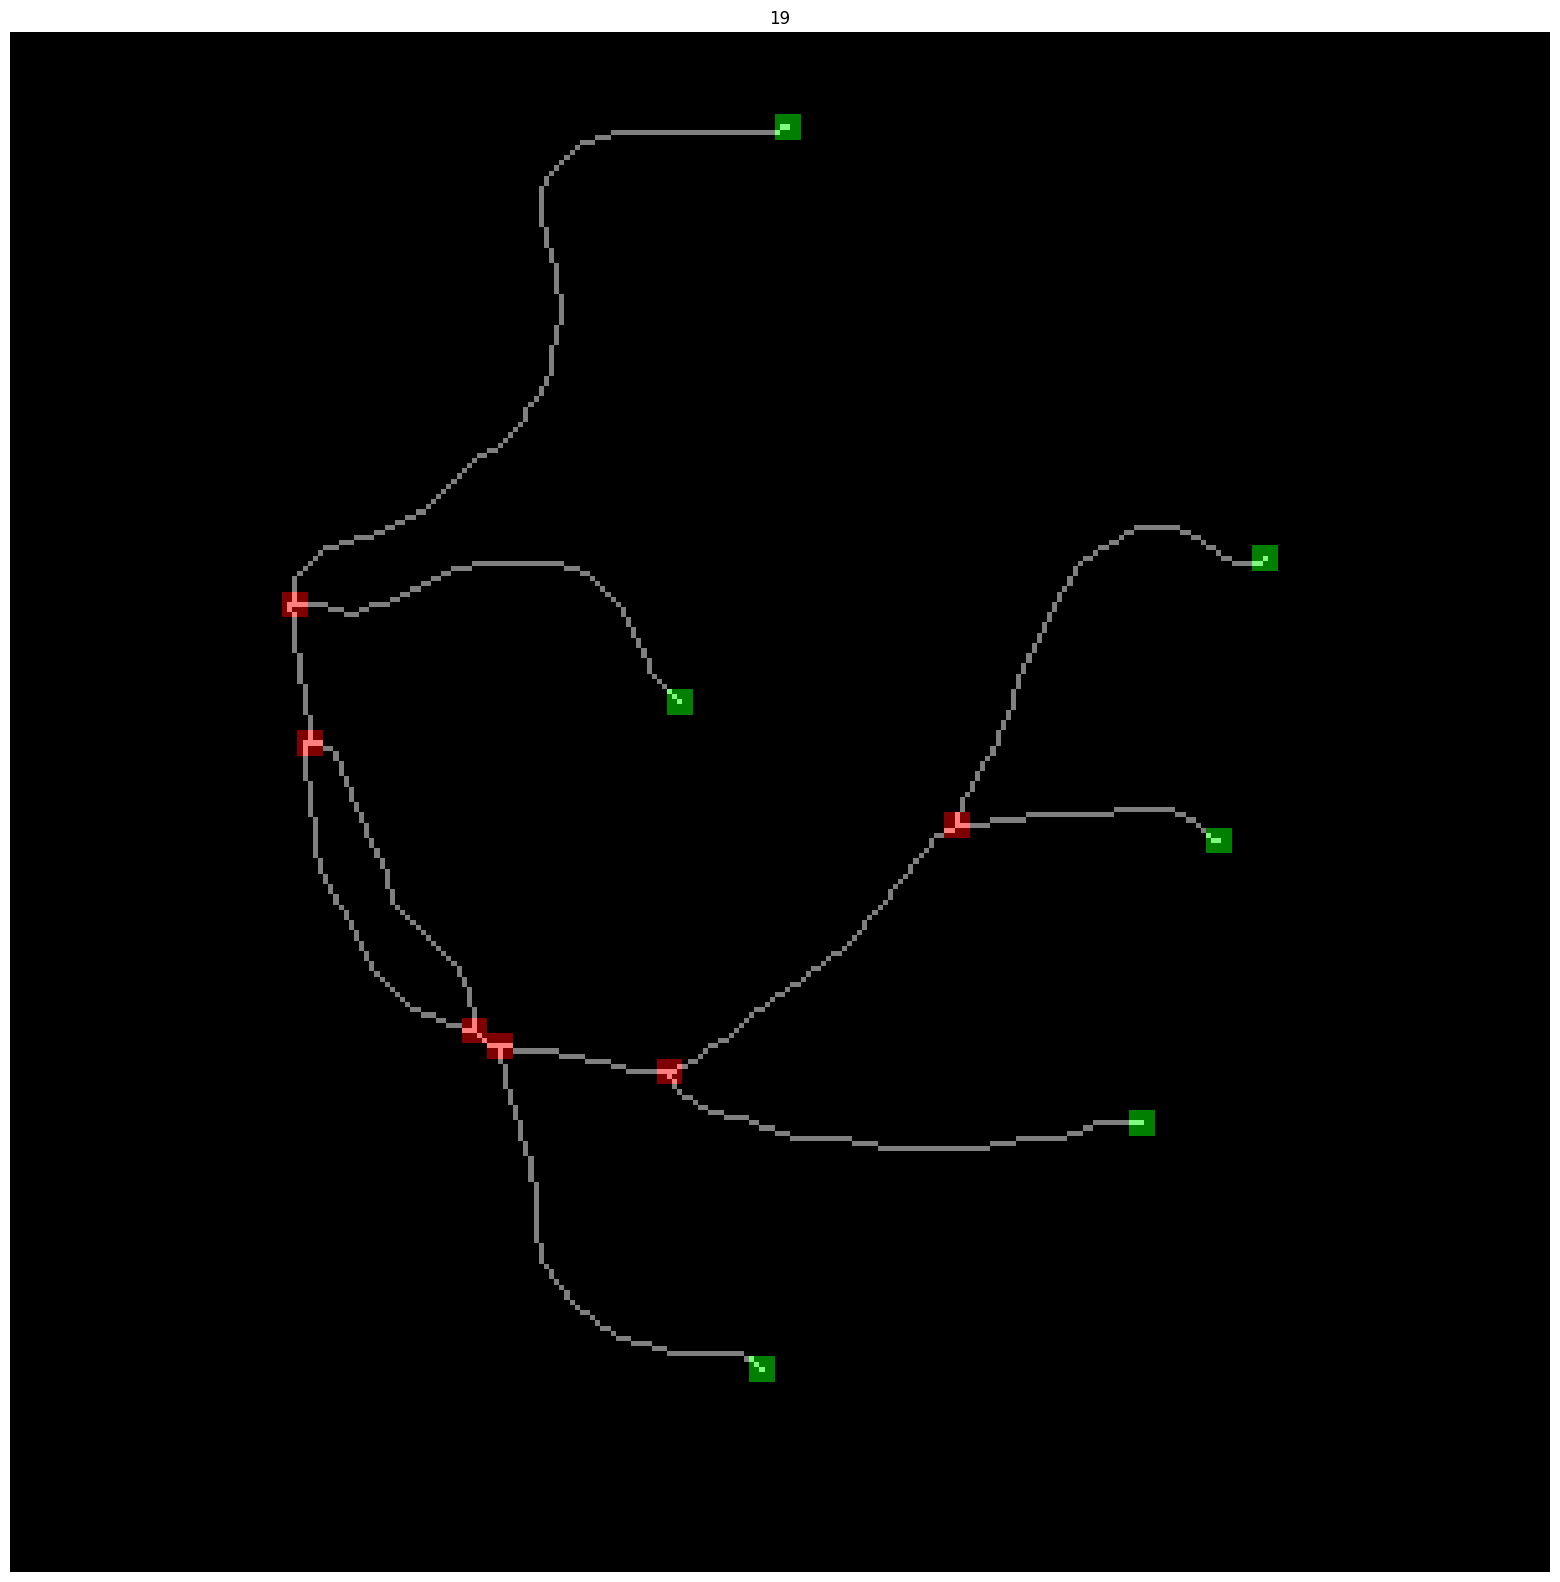

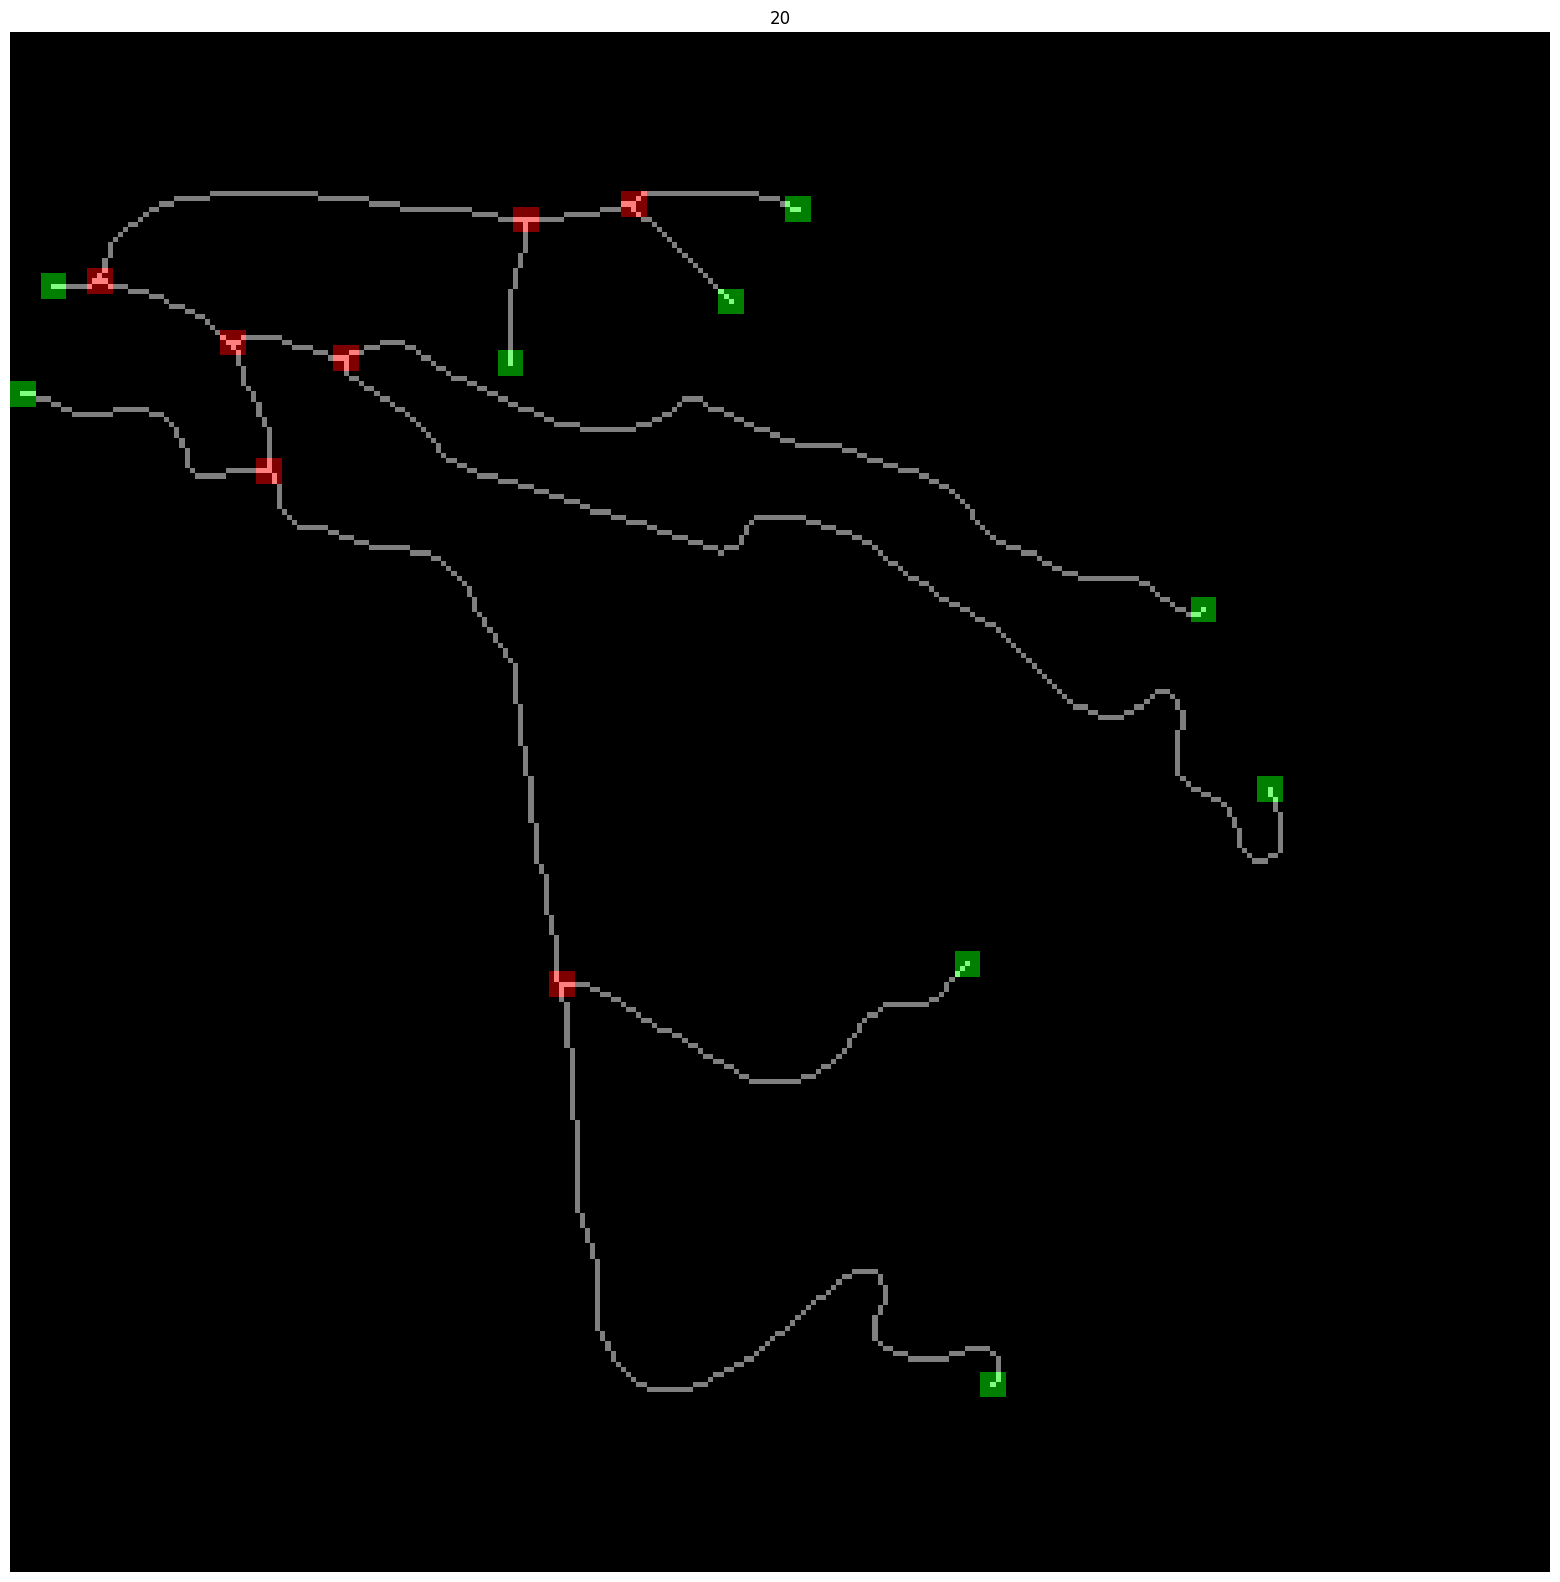

In [51]:
for i in range(1,21):
    I = plt.imread(f'database/{i}_gt.pgm')
    I = I/255
    #I = (ski.color.rgb2gray(I* 255)).astype(np.uint8)
    T = skeletonize(I)
    # Supongamos que R, G y B son imágenes en escala de grises con el mismo tamaño
    R0 = detector(T,S1) + detector(T,S2) + detector(T,S3) + detector(T,S4) # Canal Rojo
    G0 = detector(T,S1f) + detector(T,S2f)    # Canal Verde
    B0, R0 = separarDT(R0,4)
    # colocar puntos
    R = mo.dilation(R0, se3) 
    G = mo.dilation(G0, se3) 
    B = mo.dilation(B0, se3) 
    # Normalizar a rango [0,1] si es necesario
    R = R / np.max(R)
    G = G / np.max(G)
    #B = B / np.max(B)
    if np.max(B) > 1:
        B = B / np.max(B)
    R = (R+T) /2
    G = (G+T) /2
    B = (B+T) /2
    # Combinar los 3 canales en una imagen RGB
    RGB_image = np.stack((R, G, B), axis=-1)  # Shape: (100, 100, 3)
    
    # Mostrar la imagen resultante
    plt.figure(figsize=(20,20))
    plt.title(i)
    plt.imshow(RGB_image)
    plt.axis("off")  # Ocultar ejes
    plt.show()

In [6]:
import json
from skimage import morphology as mo
import numpy as np
import matplotlib.pyplot as plt
import skimage as ski
from skimage.morphology import skeletonize
from scipy import ndimage as ndi
import cv2 as cv
import networkx as nx

# Custom JSON encoder to handle NumPy data types
class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        return super().default(obj)

# Definición de los kernels para la detección de nodos
S1 = np.array(([ 0,-1, 0], [ 1, 1, 1], [-1, 1,-1]), dtype="int")
S2 = np.array(([0, -1, 1], [1, 1, -1], [-1, 1, 0]), dtype="int")
S3 = np.array(([ 0,-1, 1], [ 1, 1,-1], [ 0,-1, 1]), dtype="int")
S4 = np.array(([-1,-1, 1], [-1, 1,-1], [ 1,-1, 1]), dtype="int")
S1f = np.array(([-1,-1,-1], [ 1, 1,-1], [-1,-1,-1]), dtype="int")
S2f = np.array(([-1,-1, 1], [-1, 1,-1], [-1,-1,-1]), dtype="int")

def detector(I, S):
    I = I.astype(np.uint8)
    H = I[:,:] * 0
    for i in range(4):
        S = np.rot90(S)
        H = H + cv.morphologyEx(I, cv.MORPH_HITMISS, S)
    return H

def separarDT(R0, threshold):
    B0 = np.zeros_like(R0)
    B0[R0 > threshold] = 1
    R0[R0 > threshold] = 0
    return B0, R0

# Crear el grafo
def create_graph(skeleton, R, G_channel, B):
    graph = nx.Graph()
    nodes = {}
    node_id = 0

    # Función para agregar nodos con prioridad
    def add_node(y, x, node_type):
        key = f"{y}_{x}"
        if key in nodes:
            existing_type = nodes[key]['type']
            # Mantener prioridad Trifurcation > Bifurcation > Endpoint
            priority = {'trifurcation': 3, 'bifurcation': 2, 'endpoint': 1}
            if priority[node_type] > priority[existing_type]:
                nodes[key]['type'] = node_type
        else:
            nodes[key] = {'id': int(node_id), 'x': int(x), 'y': int(y), 'type': node_type}
            graph.add_node(node_id, pos=(x, y), type=node_type)

    # Agregar nodos en orden de prioridad
    for y, x in zip(*np.where(B > 0)):
        add_node(y, x, 'trifurcation')
    for y, x in zip(*np.where(R > 0)):
        add_node(y, x, 'bifurcation')
    for y, x in zip(*np.where(G_channel > 0)):
        add_node(y, x, 'endpoint')

    # Agregar nodos intermedios (no sobrescriben los anteriores)
    for y, x in zip(*np.where(skeleton > 0)):
        key = f"{y}_{x}"
        if key not in nodes:
            nodes[key] = {'id': int(node_id), 'x': int(x), 'y': int(y), 'type': 'intermediate'}
            graph.add_node(node_id, pos=(x, y), type='intermediate')

    # Conectar nodos
    for key1, node1 in nodes.items():
        y1, x1 = map(int, key1.split('_'))
        for key2, node2 in nodes.items():
            y2, x2 = map(int, key2.split('_'))
            if (y1, x1) != (y2, x2) and abs(y1 - y2) <= 1 and abs(x1 - x2) <= 1:
                graph.add_edge(node1['id'], node2['id'])

    return graph, nodes


# Procesar cada imagen
def process_image(i):
    I = plt.imread(f'database/{i}_gt.pgm')
    I = I / 255
    T = skeletonize(I)

    # Detectar nodos
    R0 = detector(T, S1) + detector(T, S2) + detector(T, S3) + detector(T, S4)
    G0 = detector(T, S1f) + detector(T, S2f)
    B0, R0 = separarDT(R0, 4)

    # Dilatar los nodos para visualización
    se3 = mo.square(3)
    R = mo.dilation(R0, se3)
    G = mo.dilation(G0, se3)
    B = mo.dilation(B0, se3)

    # Normalizar
    R = R / np.max(R)
    G = G / np.max(G)
    if np.max(B) > 1:
        B = B / np.max(B)

    R = (R + T) / 2
    G = (G + T) / 2
    B = (B + T) / 2

    # Crear el grafo
    graph, nodes = create_graph(T, R, G, B)

    # Guardar la información en JSON
    with open(f'graph_{i}.json', 'w') as f:
        json.dump(nodes, f, indent=4, cls=NumpyEncoder)  # Use custom encoder

    # Visualizar la imagen
    RGB_image = np.stack((R, G, B), axis=-1)
    plt.figure(figsize=(20, 20))
    plt.title(i)
    plt.imshow(RGB_image)
    plt.axis("off")
    plt.show()

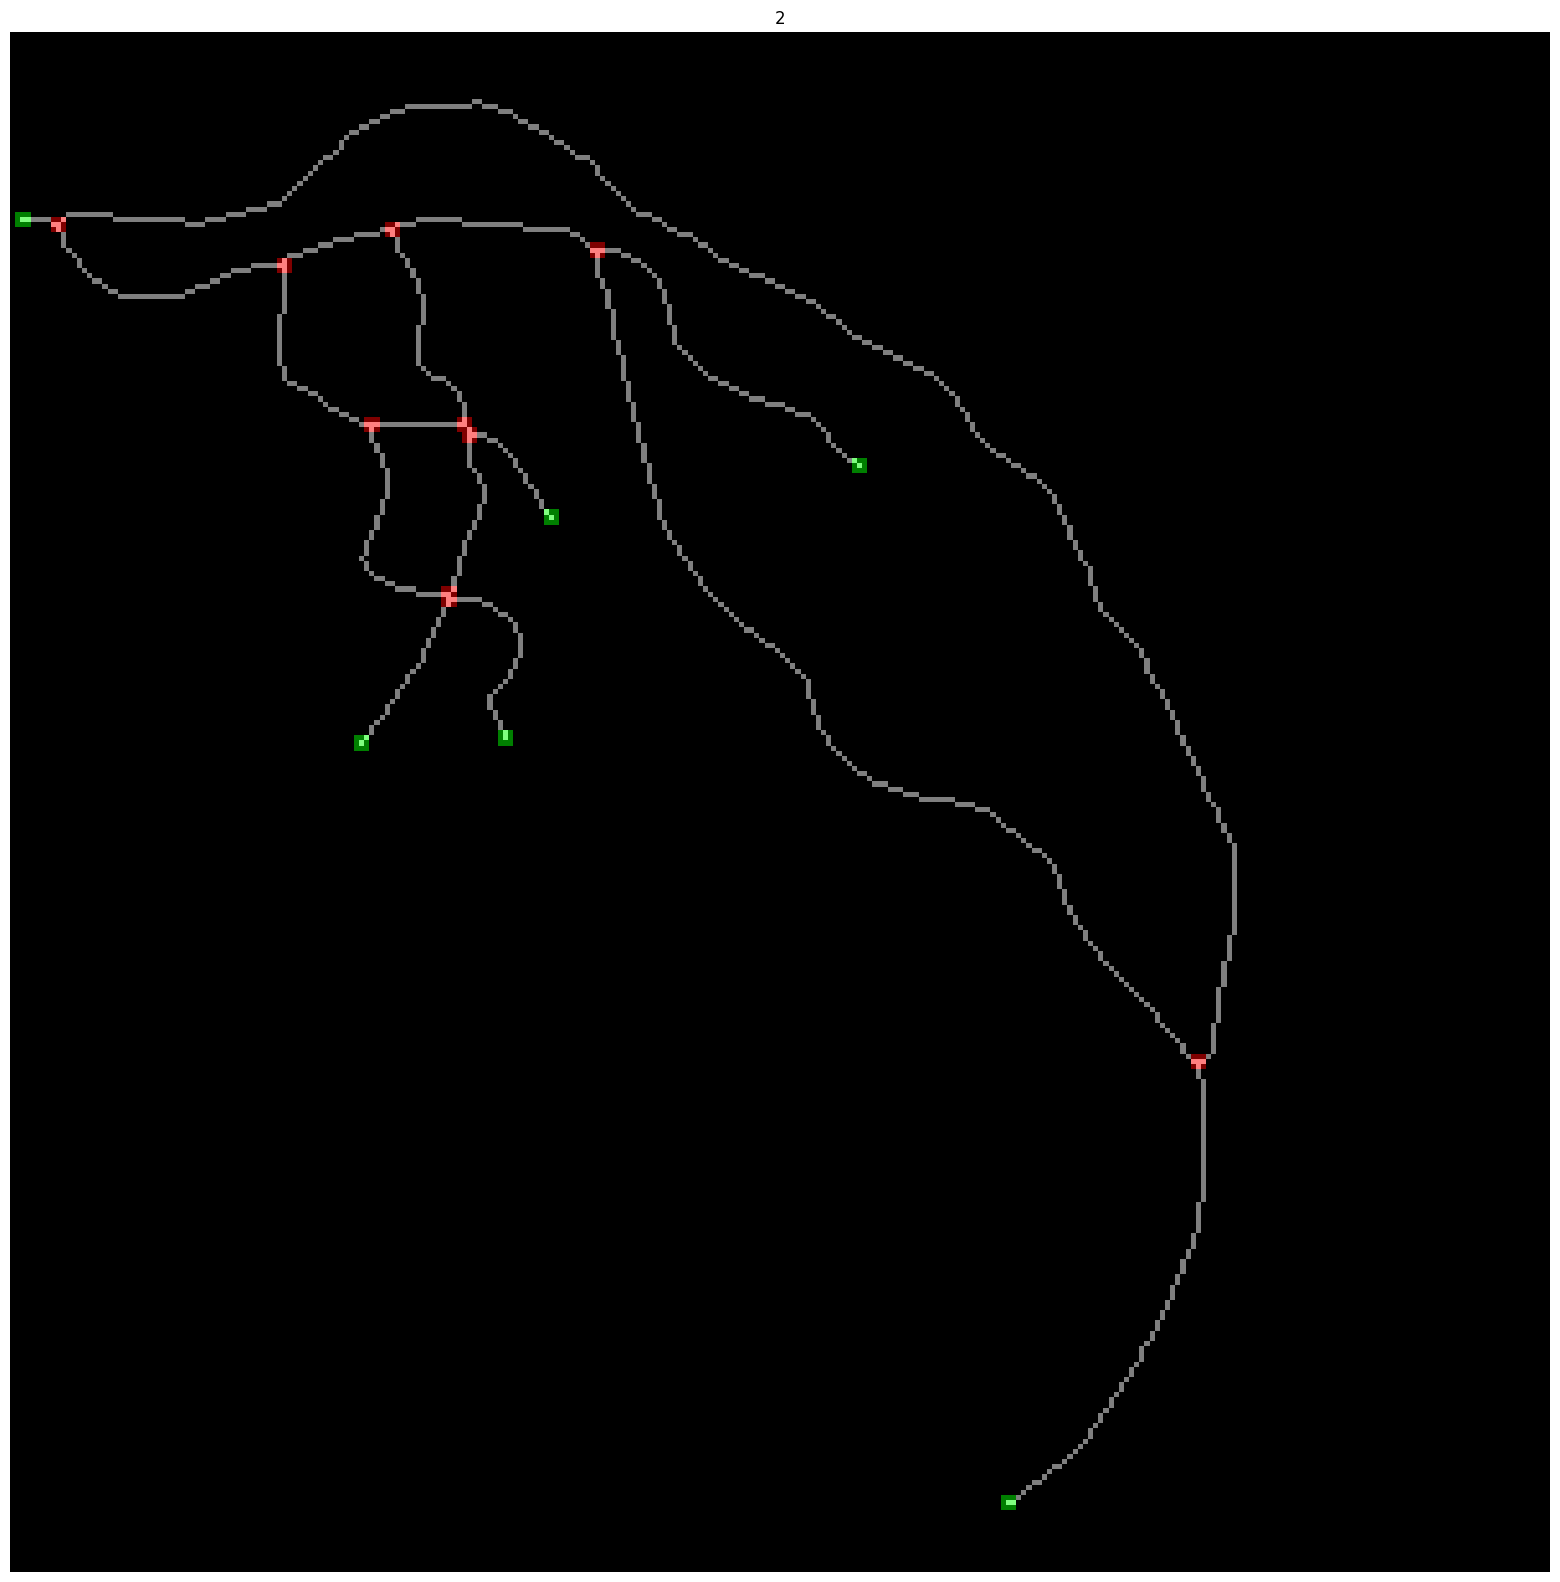

In [7]:
process_image(2)